In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import boto3 as boto3
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.float_format', '{:.4f}'.format)


In [2]:
pd.set_option('display.max_columns', 500)

df = pd.read_csv("C:/Users/lucab/Documents/FTT/EC/web_api_final.csv", sep=",", low_memory=False)
df = df[df.condition != 'not_specified']
primeiroFiltroVariaveis = df.copy()

In [3]:
columnsList = ['address_state_name', 'price', 'condition', 'modelo_upper', 'marca_y',
       'modelo_y', 'é_dual_sim', 'memoria_interna', 'com_camera',
       'com_bluetooth', 'tamanho_da_tela', 'com_wi-fi', 'linha_y', 'com_gps',
       'com_acelerometro', 'memoria_ram', 'com_conector_usb',
       'tamanhos_de_cartao_sim_compatíveis',
       'quantidade_de_ranhuras_para_cartao_sim', 'capacidade_da_bateria',
       'quantidade_de_núcleos_do_processador',
       'com_leitor_de_impressao_digital', 'rede',
       'quantidade_de_cameras_traseiras', 'velocidade_do_processador',
       'quantidade_de_cameras_frontais', 'modelo_do_processador_y',
       'ano_de_lançamento', 'com_flash_na_camara_frontal',
       'tipo_de_conector_de_carregamento', 'é_a_prova_d_agua',
       'é_resistente_a_agua', 'modelo_de_gpu_y', 'com_nfc',
       'tipos_de_cartao_de_memoria', 'com_carregamento_rapido', 'memory',
       'sistema_operacional']

listBooleanVariables = [
    'é_dual_sim','com_camera','com_bluetooth','com_wi-fi','com_gps',
    'com_acelerometro','com_conector_usb','com_flash_na_camara_frontal',
    'é_resistente_a_agua','com_nfc','com_carregamento_rapido','com_leitor_de_impressao_digital',
    'é_a_prova_d_agua','condition']


In [4]:
#Tratamento nome das colunas 
import re
variables = primeiroFiltroVariaveis.columns
# Colunarização da tabela

for n in variables:
    primeiroFiltroVariaveis = primeiroFiltroVariaveis.rename({
    n : re.sub('(\')|(\.)','_',re.sub('ó|ô','o',re.sub('é_','e_',re.sub('ã|â|á|à','a',re.sub(' ','_',n))))).lower()
    }, axis=1
    )
    
#Tratando as colunas valores das colunas 

listColumnsUpper = [
    'nome_do_sistema_operacional'
]

for a in listColumnsUpper:
    primeiroFiltroVariaveis[a] = primeiroFiltroVariaveis[a].str.upper()

condition = [
    primeiroFiltroVariaveis.nome_do_sistema_operacional.str.contains('.*ANDR.*', regex = True,na=False),
    primeiroFiltroVariaveis.nome_do_sistema_operacional.str.contains('.*IOS.*', regex = True,na=False)
]

value = [
    'ANDROID',
    'IOS'
]

primeiroFiltroVariaveis['sistema_operacional'] = np.select(condition, value, default='unknown')

primeiroFiltroVariaveis = primeiroFiltroVariaveis[columnsList]


for a in listBooleanVariables:
    if a == 'condition':
        primeiroFiltroVariaveis[a] = primeiroFiltroVariaveis[a].map(dict(used=1, new=0))
        primeiroFiltroVariaveis[a] = pd.to_numeric(primeiroFiltroVariaveis[a]).fillna(0)
    else:
        primeiroFiltroVariaveis[a] = primeiroFiltroVariaveis[a].map(dict(Sim=1, Não=0))
        primeiroFiltroVariaveis[a] = pd.to_numeric(primeiroFiltroVariaveis[a]).fillna(0)   
        
primeiroFiltroVariaveis = primeiroFiltroVariaveis[primeiroFiltroVariaveis['memoria_interna'].str.contains("GB",na=False)]
primeiroFiltroVariaveis = primeiroFiltroVariaveis[primeiroFiltroVariaveis['memoria_ram'].str.contains("GB",na=False)]
primeiroFiltroVariaveis = primeiroFiltroVariaveis[primeiroFiltroVariaveis['velocidade_do_processador'].str.contains("GHz",na=False)]

primeiroFiltroVariaveis['memoria_interna'] = primeiroFiltroVariaveis['memoria_interna'].str.replace(' GB', "")
primeiroFiltroVariaveis['memoria_ram'] = primeiroFiltroVariaveis['memoria_ram'].str.replace(' GB', "")
primeiroFiltroVariaveis['tamanho_da_tela'] = primeiroFiltroVariaveis['tamanho_da_tela'].str.replace('(\")', "")
primeiroFiltroVariaveis['capacidade_da_bateria'] = primeiroFiltroVariaveis['capacidade_da_bateria'].str.replace('(mAh|Ah)', "")
primeiroFiltroVariaveis['velocidade_do_processador'] = primeiroFiltroVariaveis['velocidade_do_processador'].str.replace('(GHz)', "")
 
primeiroFiltroVariaveis['memoria_interna'] = pd.to_numeric(primeiroFiltroVariaveis['memoria_interna'])
primeiroFiltroVariaveis['memoria_ram'] = pd.to_numeric(primeiroFiltroVariaveis['memoria_ram'])
primeiroFiltroVariaveis['capacidade_da_bateria'] = pd.to_numeric(primeiroFiltroVariaveis['capacidade_da_bateria'])
primeiroFiltroVariaveis['velocidade_do_processador'] = pd.to_numeric(primeiroFiltroVariaveis['velocidade_do_processador'])


primeiroFiltroVariaveis = primeiroFiltroVariaveis[primeiroFiltroVariaveis.sistema_operacional != 'unknown']


C:\Users\lucab\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\lucab\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\lucab\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: The default value of regex will change from True to False in a future version.


In [5]:
base_modelo = primeiroFiltroVariaveis.rename({
    'modelo_y': 'Modelo',
    'linha_y': 'Linha',
    'marca_y': 'Marca'  
}, axis=1)

In [6]:
## Parte para fazer um case when e fazer uma nova coluna chamada modelo

# create a list of our conditions
conditions = [
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT 2010-1') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt2041') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2091') & (base_modelo.Linha == '')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'zb634kl') & (base_modelo.Linha == 'Series 6')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'FONES')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Pro')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with charging case (1st generation)') & (base_modelo.Linha == 'Series 4')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with charging case (1st generation)') & (base_modelo.Linha == 'Basic')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Apple watch 4 40mm') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Apple watch Nike se 44mm a2352 GPS') & (base_modelo.Linha == 'Apple watch Nike se 44mm a2352 GPS')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Apple watch se 40mm A2355') & (base_modelo.Linha == 'Apple watch se 40mm A2355')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Max') & (base_modelo.Linha == 'AirPods')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Nike 5 cel e gps') & (base_modelo.Linha == 'Series 5')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Nike+') & (base_modelo.Linha == 'Series 2')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Nike+ (GPS + Cellular)') & (base_modelo.Linha == 'Series 4')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Pencil') & (base_modelo.Linha == 'caneta touch')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'pro max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'serie 5') & (base_modelo.Linha == 'Watch')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch') & (base_modelo.Linha == 'Series 6')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch') & (base_modelo.Linha == 'Series 5')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch') & (base_modelo.Linha == 'Series 3')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch') & (base_modelo.Linha == 'Series 2')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch (GPS + Cellular)') & (base_modelo.Linha == 'Series 6')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch (GPS + Cellular)') & (base_modelo.Linha == 'Series 4')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch (GPS + Cellular)') & (base_modelo.Linha == 'Series 3')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch (GPS)') & (base_modelo.Linha == 'Series 6')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch (GPS)') & (base_modelo.Linha == 'Series 5')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch (GPS)') & (base_modelo.Linha == 'Series 4')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch (GPS)') & (base_modelo.Linha == 'Series 3')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch Nike') & (base_modelo.Linha == 'Series 6')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch SE') & (base_modelo.Linha == '')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch SE') & (base_modelo.Linha == 'SE')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == '8050E') & (base_modelo.Linha == 'DGP')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'A3') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Acclaim SCH-R880') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Black Shark') & (base_modelo.Linha == 'Black Shark')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Black Shark 3') & (base_modelo.Linha == 'Black Shark')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'F1') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Fitness') & (base_modelo.Linha == 'D20')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Fold') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'GALAXY') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'GTR') & (base_modelo.Linha == 'Amazifit')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'GTR 2') & (base_modelo.Linha == 'Amazifit')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'GTR 2E') & (base_modelo.Linha == 'Amazifit')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'GTS 2 A1969') & (base_modelo.Linha == 'Amazfit A1969')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note 8 Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco C3') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8 Plus Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8 Power Lite Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G9 Play Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G9 Plus Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == '5') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A01 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A10 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A10s Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SAMSUNG A11') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A11') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A11 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A12 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A12') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A12') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A20') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A20 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A20s') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A20s Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A21') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A21 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A21s Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A21s') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A30') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A30 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A30s Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A30s') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A31 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A31') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A5 (2017) Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A50 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A50') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A50s') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A51') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A51 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A51 5G Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == '(SM-A605GN/DS)') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A6+ Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A7 (2018) Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A7 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A70') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A70 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A71') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A71 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A71 5G Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A8 (2018) Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A8 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A8+ Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A80') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A80 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A80 rose') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A9 (2018)') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A9 (2018) Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J6 TV') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J6+ Duos') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Prime 2') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Prime 2 TV') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Pro Duos') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J8') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J8 Duos') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'M10 Duos') & (base_modelo.Linha == 'Galaxy M')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'M21s') & (base_modelo.Linha == 'Galaxy M')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'M30 Duos') & (base_modelo.Linha == 'Galaxy M')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'M31') & (base_modelo.Linha == 'Galaxy M')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'M51') & (base_modelo.Linha == 'Galaxy M')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note10+ Duos') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note10+') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note20 Ultra 5G Duos') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S10') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S10') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S10 Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S10+') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S10+ Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S10+') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S10e') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S10e Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S20') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20 FE') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20 FE Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S20 Plus') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20+ Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S8 Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S9') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S9 Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S9') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S9+ Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Xcover') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'XCover Pro') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Z Flip') & (base_modelo.Linha == 'Galaxy Z')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Z Fold2') & (base_modelo.Linha == 'Galaxy Z')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'IPhone 11 64g') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MHDK3BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MHDQ3BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '11 pro') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 Pro') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 Pro Max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 12') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 12 mini') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 12 Pro') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 12 Pro Max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MGD83BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MGD93BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 4') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 4s') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 5') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '6s') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6s') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6 Plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6s Plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 32g') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'I PHONE 7 128 gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '7 Plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 Plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 Plus 128g') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '8') & (base_modelo.Linha == 'Iphone 8')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 8') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '8 Plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 8 Plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone SE') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone SE (2nd Generation)') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone X') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'X') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XR') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XS') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XS Dual SIM') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XS gold') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'XS MAX') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XS Max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XS Max 256 GG') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 10 Lite') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10 Dual SIM') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 10 Coral Green') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10 Lite') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10T 5G') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10T Lite 5G') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10T Pro 5G') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '11') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '8') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '8 Lite') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 8 lite') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '8 Pro') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9 Transparent Edition') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9 Lite') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9 SE') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9T') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9T Pro') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 9 t pro') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'A2') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'A2 Lite') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'A3') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mix 2S') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mix 3') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mix 3 5G') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 10') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Play') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6s (2020) Dual SIM') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z2 Force') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z2 Force Dual SIM') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z2 Play Dual SIM') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z2 Play GamePad Edition') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z3 Play') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z3 Play Dual SIM') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z3 Play Power Pack & DTV Edition') & (base_modelo.Linha == 'Moto Z3')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Fusion Dual SIM') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note S10 Lite') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'Pocophone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'Top de linha')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'ZenFone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F2 Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F2 Pro') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Pocophone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Poco')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Sim')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Sim')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == '')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == '1')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Armor Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Black Shark')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Iwo W46')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Fone Ouvido')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'POCO M3')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Galaxy M')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Mobi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Spartan')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Moto C')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'RAZR')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Sim')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Pocophone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Pocophon')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Encok')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Mate Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'S Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'RAZR')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Pocophone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Poco')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Moto C')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'V8s')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'MS45')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == '')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'D20')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Edge')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Galaxy M')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Sem Fio')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Lumia')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Xiaomi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Xperia')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'xiaomi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'POCOPHONE')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 10 Pro') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10X 4G') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '5 Plus') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '7') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '8') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '8A') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 8A') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9 (Global)') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9 (India)') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9 India') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 9') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9 Power') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9 Prime') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9A') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9C') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9i') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9s') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9T') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'K20') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'K30') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 5') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 7 (48 Mpx)') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 8') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 8 Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 8T') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9 Pro (64 Mpx)') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9 4G') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9 pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9 Pro (48 Mpx)') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9 Pro Max') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9T') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9S') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pro (Helio X20)') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'S2') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'A920') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'C Plus Dual SIM') & (base_modelo.Linha == 'Moto C')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'D20') & (base_modelo.Linha == 'D20')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'DEP 450 Analógico') & (base_modelo.Linha == 'Mototrbo')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'DGM 8000') & (base_modelo.Linha == 'Canvas Select Plus')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E4 Plus Dual SIM') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E5 Dual SIM') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6 Plus') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E7 Dual SIM') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E7 Plus') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E7 Plus Dual SIM') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Edge') & (base_modelo.Linha == 'Edge')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Edge Dual SIM') & (base_modelo.Linha == 'Edge')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Edge+') & (base_modelo.Linha == 'Edge')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'EP450 EM200') & (base_modelo.Linha == 'Profissional')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G 5G') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G4 Play Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G4 Plus Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5 Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5S Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5S Plus Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Plus') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7 Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7 Play') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7 Plus Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7 Power Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8 Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8 Play') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8 Plus') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8 Power') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8 Power Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8 Power Lite') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8 Power Lite Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G9 Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G9 Play') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G9 Plus') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G9 Power') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G9 Power Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G8 Branco prism') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G9 Play') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto one macro') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola G8') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Normal') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note10') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note10 Duos') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note10 Lite') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note10 Lite Duos') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note10+ 5G Duos') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note20') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note20 5G') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note20 5G Duos') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note20 Ultra') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note20 Ultra 5G') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note8') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note8 Duos') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note9') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note9 Duos') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Action') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Action Dual SIM') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Dual SIM') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Fusion') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Fusion+ Dual SIM') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Hyper') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Hyper Dual SIM') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Macro') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Macro Dual SIM') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Vision') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Vision Dual SIM') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Zoom') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'PRO5150 IS') & (base_modelo.Linha == 'PRO')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'RAZR 2019') & (base_modelo.Linha == 'RAZR')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'RAZR D1 Dual SIM') & (base_modelo.Linha == 'RAZR')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'relogio') & (base_modelo.Linha == 'Gear')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S10 Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S10 Lite') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S10 Lite Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S10+') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S10e Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20 Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20 FE 5G') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20 Ultra') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20 Ultra 5G') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20 Ultra Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20+') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20+ 5G BTS Edition Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20+ 5G Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20+ 5G Enterprise Edition') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20+ BTS Edition Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S21 5G Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S21+ 5G') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S3 Classic') & (base_modelo.Linha == 'Gear')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S5') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S6 Edge+') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S7') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S7 Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S7 Edge') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S8') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S8+') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S8+ Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S9 Duos - Galaxy S9 Usado') & (base_modelo.Linha == 'Galaxy - Galaxy S9 - Galaxy S9 Usado - Celular...')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S9+') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A015MZKSZTO') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A125M/64DL') & (base_modelo.Linha == 'A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A125MZBSZTO') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A125MZRSZTO') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A715') & (base_modelo.Linha == 'Galaxy A71')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-G715U1/64D') & (base_modelo.Linha == 'Xcover')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-G975F') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Smartphone') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Smartphone') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Smartphone') & (base_modelo.Linha == 'Galaxy M')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Tela 6') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Tela 6') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'V3 D&G') & (base_modelo.Linha == 'V')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Watch (Bluetooth)') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Watch Active 2') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Watch3') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'X Play') & (base_modelo.Linha == 'Moto X')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'X4 Dual SIM') & (base_modelo.Linha == 'Moto X')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '6') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '7') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '8') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '8') & (base_modelo.Linha == 'IPHONE')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '1') & (base_modelo.Linha == 'SE Sport Band')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '2') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '11') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '12') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '12') & (base_modelo.Linha == 'Pop')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '3') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '44412') & (base_modelo.Linha == 'Suporte Aranha De Celular Para Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '4') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '!IPhone SE 2020 Red!') & (base_modelo.Linha == 'SE')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '11 128gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '6') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '11 64g') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '11 64gb Amarelo') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '6') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '11 pro max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '11 pro Max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '11 Pro max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '11 Pro Max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '11 pro max 256') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '11 pro max 256gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '2020') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '11 PRO MAX 256GB') & (base_modelo.Linha == '11 PRO MAX')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10 Extreme Commemorative Edition') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S21 Ultra 5G Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '11910753571 NÚMERO DA EMPRESA') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10 Lite') & (base_modelo.Linha == 'Pulse')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10 Pro') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S21+ 5G Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10 Pro Dual SIM') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10 Ultra') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10 Youth 5G') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10i') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '12 64gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '12 Mini 64Gb (Semi - Novo)') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10S') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '12 pro') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '12 pro Max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10T Pro 5G') & (base_modelo.Linha == 'TFT-LCD')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S21 5G') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '10X Pro 5G') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '11 Lite') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '11 Lite') & (base_modelo.Linha == 'Mi 11')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '11 LITE') & (base_modelo.Linha == 'Mi 11')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '11 LITE') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == '6') & (base_modelo.Linha == 'Nexus')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == '8') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '2S') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '3S') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == '100') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '4GB de RAM 64GB') & (base_modelo.Linha == 'Andróide')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == '200') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '5s') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '12 Pro Max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '6 Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '64GB Forest Green') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '6A') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == '200') & (base_modelo.Linha == 'Optimus')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '12 pro Max 512 gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A72 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S21 Ultra 5G') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == '8700') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '7A') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == '8700') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A52 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == '128GB') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == '811084') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '7A (12 Mpx)') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == '236C') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '7A (13 Mpx)') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A32 5G Dual SIM') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '2 iPhone SE sendo o outro 64 gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '8 Explorer Edition') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == '6P') & (base_modelo.Linha == 'Nexus')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '32gb plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S6 Edge') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == '236C') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S6') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '8A Dual') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A32 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == '306G') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '8a Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == '(n/d)') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Activa 4G') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9 Explorer Edition') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == '(xt1929-5)') & (base_modelo.Linha == 'RIZR')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A31 Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SAMSUNG') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9 Pró') & (base_modelo.Linha == 'Note')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'A1000') & (base_modelo.Linha == 'Moto C')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9A') & (base_modelo.Linha == '7898570000000')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9A') & (base_modelo.Linha == '6941060000000')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A10s') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '4s, 5, 5s') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == '306G') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9AT') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'A1010') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9C NFC') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9i') & (base_modelo.Linha == 'Redmi 9I')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'A100') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9s') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A02s Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A52 5G Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'XCover Pro Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S20') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'A1210') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '5s') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'A300') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9T') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note20 Ultra') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'A388') & (base_modelo.Linha == 'Moro')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S9 Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '6 Plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9T') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Plus') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A02s Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '6s') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'A728') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A51 5G Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S10') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '6s') & (base_modelo.Linha == 'IPHONE DOURADO MAÇA OURO')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '6S - iPhone 6s - iFone - Celular - Apple - Sma...') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note20 Duos') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9T') & (base_modelo.Linha == 'Note')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '6S - MG32BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'A170') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'A1 Special Edition Red') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'A235') & (base_modelo.Linha == 'Q Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20 Ultra 5G Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S9+ Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'FreeBuds Pro') & (base_modelo.Linha == 'Bluetooth 5.2 Global')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '6S 4.7') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'A732') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'AirDots') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note4') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'AirDots') & (base_modelo.Linha == 'Air')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'B220') & (base_modelo.Linha == 'B220')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Chocolate 3 VX8560') & (base_modelo.Linha == 'Black Label Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'AirDots 2') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'F60') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '6S 4.7') & (base_modelo.Linha == '6S')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'A810') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'A845') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'A920') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '6s plu') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A10s Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A6+') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Black Shark 2') & (base_modelo.Linha == 'Black Shark')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Adventure V750') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Black Shark 2 Pro') & (base_modelo.Linha == 'Black Shark')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A8+') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A31') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Flex') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '6S Plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Black Shark 3S') & (base_modelo.Linha == 'Black Shark')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Z Fold2 5G') & (base_modelo.Linha == 'Galaxy Z')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G2') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G3') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A01 Core Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '6s plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Black Shark 4') & (base_modelo.Linha == 'Black Shark')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A12 Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'ATRIX 4G MB860') & (base_modelo.Linha == 'ATRIX')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A32 5G Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A32 Duos') & (base_modelo.Linha == 'A32')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Prime') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'ATRIX TV XT682') & (base_modelo.Linha == 'ATRIX')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '7 - iPhone - iPhone 7 - Apple - Celular - Smar...') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'CC9') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'CX301AZU') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A71 Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S9 Plus') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G4') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'C') & (base_modelo.Linha == 'Moto C')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '7 - iPhone 7 - iPhone 7 Usado - iPhone 7 32GB ...') & (base_modelo.Linha == 'iPhone - iPhone 7 - 7 - Celular - Smartphone -...')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'F2 Pro') & (base_modelo.Linha == 'Fone de Ouvido para Celular com Fio e Microfon...')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'C Dual SIM') & (base_modelo.Linha == 'Moto C')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '7 Gold 128G') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'F3') & (base_modelo.Linha == 'Poco')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G4 Dual') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'F3') & (base_modelo.Linha == 'POCO')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'C Plus') & (base_modelo.Linha == 'Moto C')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G4 S') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'F3') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A10') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A7 (2018)') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Duos') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'GTR 2') & (base_modelo.Linha == 'Fashion')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A11 Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J6+') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'iPhone X') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20 FE 5G Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'C385') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G4 Stylus 4G') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G4 Stylus Dual SIM') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'C650') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20+ Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '7 iPhone 32') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S8+ Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'J4') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'K20 Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G5') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'CE0168 não tem capin') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A01') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Huawei P30 Pro 256gb') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'DEM 300') & (base_modelo.Linha == 'Ultra')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A10s NEW PTO') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A32') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'K20 Pro Premium') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A52 Duos') & (base_modelo.Linha == 'A52')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Buds Pro(SM-R190)') & (base_modelo.Linha == 'Buds')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'K30 5G') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'K40') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S9') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G5 SE') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S21 5G 128 VTL') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'DEM 400') & (base_modelo.Linha == 'LEMFO KT48')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S21 Ultra 5G 256 PTA') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'DEM 400 VHF') & (base_modelo.Linha == 'D20')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S21+ 5G 128 PTO') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S21+ 5G 256 PTO') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '7 Plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A02 AZL') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Lake green') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '7 Plus 128 GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A02 VML') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G6') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A02s PTO') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A02s VML') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Pro') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '7 plus 32') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note20 Ultra Duos') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G6 Dual') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S7 Edge Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'dem500') & (base_modelo.Linha == 'Mototrbo')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'DEP 450 Digital') & (base_modelo.Linha == 'Mototrbo')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'LG Prime Plus (TV Dual H502TV)') & (base_modelo.Linha == 'Premium')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'ma5800') & (base_modelo.Linha == 'ZenFone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'DGM 4100+') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Dgm8000') & (base_modelo.Linha == 'Mototrbo')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'DGMs') & (base_modelo.Linha == 'Mototrbo')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Lite A1915') & (base_modelo.Linha == 'Basic')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'DLR 1060') & (base_modelo.Linha == 'Digital')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'DTR 620') & (base_modelo.Linha == 'Profissional')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A21s Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A5') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Evo Plus') & (base_modelo.Linha == 'Evo Plus')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G7 ThinQ') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A9 2018') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G7 ThinQ Dual SIM') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'M1901F7H') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note5') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'M2004J19AG') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'M3') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S21+ 5G 128 VTL') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S21+ 5G 256 PTA') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'DTR 620') & (base_modelo.Linha == 'DTR')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'DTR720') & (base_modelo.Linha == 'Digital')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Max 3') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 10') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 10 128gb') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 10T') & (base_modelo.Linha == 'Series 3')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G7+ ThinQ') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '7 plus Red') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G8 ThinQ') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E (2nd Gen.) Dual SIM') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A02 Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 10T Lite') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 10T lite') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E4') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'MI 10t Lite') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E4') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A02s') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A7 (2017) Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G810') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E4 Dual SIM') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A72') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E4 Plus') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '8 - iPhone 8 - Celular - Smartphone - Celular ...') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy Note 9') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Mate 10') & (base_modelo.Linha == 'Mate Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Mate 10 Dual SIM') & (base_modelo.Linha == 'Mate Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 10t Pro ,snapdragon 865, 144Hz, Vídeos em 8...') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S20 Ultra') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E4 Plus') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S8 Plus') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G8S ThinQ') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J1 Mini Duos') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E4 Plus Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E5') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G8S ThinQ Dual SIM') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'MI 11') & (base_modelo.Linha == 'Global')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20 5G Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 11 Lite') & (base_modelo.Linha == 'Mi 11')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Smartphone') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 11 Lite') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E5 Play') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 11 lite') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 8') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '8 - iPhone 8 - iPhone - IPhone Usado - iPhone ...') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E5 Play (Go Edition) Dual SIM') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E5 Plus Dual SIM') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 9') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'mi 9 se') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 9 SE') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'MI 9 SE BLUE') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A51 Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A52') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy Note 10+') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6 Play') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J4+ Duos') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6 Play Dual SIM') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 9 t') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6 Play Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'MI 9 T PRO') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G8X ThinQ') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6 Plus Dual SIM') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'G8X ThinQ Dual SIM') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 9T') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6 Plus Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 9t') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6i') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6i') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A32 5G') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6i Dual SIM') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6s') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A7') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A7 (2016)') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A8') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6s') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A02S') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi a1 / Mi 5x') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Mate 10 Pro') & (base_modelo.Linha == 'Mate Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6S - XT2053-5') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Joy') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi A2') & (base_modelo.Linha == 'Mi A2')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K 52') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S10 Lite') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S10e') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K10') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6s (2020) Special Edition') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '8 Plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S8') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E7 Dual SIM') & (base_modelo.Linha == 'E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E7 Plus Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K10 - K430 TV / DSF / F') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E7 Power') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Edge Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Edge Dual SIM') & (base_modelo.Linha == 'MOTO EDGE DUAL SIM')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S8 G955') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '8 Plus') & (base_modelo.Linha == '8 Plus')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Edge Dual SIM') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi a3') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Edge+') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '8 Plus') & (base_modelo.Linha == 'Space Gray')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi Mix 3 5g') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Edge+') & (base_modelo.Linha == 'Moto Edge')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note3') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi note 10') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S5 Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'EP450') & (base_modelo.Linha == 'Capa Com Foto')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A115MZBGZTO') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi note 10') & (base_modelo.Linha == 'Mi note 10')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A125MZKSZTO') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A725M/DS') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi Note 10 lite') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Mate 20 Lite Dual SIM') & (base_modelo.Linha == 'Mate Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'EX128') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi Smart Band 5') & (base_modelo.Linha == 'Sport')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'EX128') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi Smart Band 6') & (base_modelo.Linha == 'Mi Band')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi Smart Band 6') & (base_modelo.Linha == 'Smartwatch')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi6') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi9') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '8 Plus 256gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '8 plus 64 g') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi9t') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '8 PLUS GOLD') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi9T') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '8 Plus Red') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G (1st Gen.) Colors Edition') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi9t pro') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G (2nd Gen.)') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G (2nd Gen.)') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A32 Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A52 5G') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'A1428 A1429 A1456 A1507 A1516 A1529 A1532 A145...') & (base_modelo.Linha == 'Zj046')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'GALAXY A-12') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G (2nd Gen.)') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A11') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A7 2018') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy M31') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Mate 20 Pro') & (base_modelo.Linha == 'Mate Series')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'A1428 A1429 A1456 A1507 A1516 A1529 A1532 A145...') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S20 FE') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'mia3') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Mate 20 Pro Dual SIM') & (base_modelo.Linha == 'Mate Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'MIA3 64G 4G') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Miband 6') & (base_modelo.Linha == 'Pulseira Inteligente')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K10 Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S7 Edge') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy Z Flip') & (base_modelo.Linha == 'Galaxy Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G (3rd Gen.) Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mix 18K') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Mate 20 X 5G') & (base_modelo.Linha == 'Mate Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mix 2') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5 Prime Duos') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J6 Duos') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K10 LTE Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K10 NOVO') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G 5G Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mix 2 Special Edition') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Prime Duos') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'A1634 A1687') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K10 NOVO') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S8 Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A025MZKVZTO') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Mate 30') & (base_modelo.Linha == 'Mate Series')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'A1660') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'a1660') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G 5G Plus') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G Fast Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A01 Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A01 Duos') & (base_modelo.Linha == 'Celular Samsung Galaxy A01')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'A1661') & (base_modelo.Linha == 'iPhone 7 Plus')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'A1723') & (base_modelo.Linha == 'iPhone SE')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A5 (2016)') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G Play (2021)') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A5 (2016) Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G Pro') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mix 3 Forbidden City Special Edition') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A5 (2017)') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G Pro Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G Stylus') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'A1778') & (base_modelo.Linha == 'Iphone 7')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G Turbo Edition') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G10') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G10') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'A1779') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'modelo M1804C3CG') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A7 (2016) Duos') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A51') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Not 9') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A7 2018') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Not 9 pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K10 Power') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K10 Power TV') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K11+') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A70') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy Note 3 SM-N900') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy Note 8') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G10 Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K11+ Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy note 9') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K12 Max') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S10e') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S21 Plus') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K12 Plus') & (base_modelo.Linha == 'LG')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K12 Prime') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J4 Duos') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K12+') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Mate 30 Pro') & (base_modelo.Linha == 'Mate Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K20') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 10') & (base_modelo.Linha == 'IWO Lite')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G10 Power') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J6') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K22') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Metal Duos') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'M11 Duos') & (base_modelo.Linha == 'Galaxy M')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S10+ Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K22 Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K22 Dual SIM') & (base_modelo.Linha == 'K')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 10') & (base_modelo.Linha == 'Mi Redmi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K22 Vivo') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Mate 30 Pro Dual SIM') & (base_modelo.Linha == 'Mate Series')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'A1863') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 10') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G100') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G100') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 10 128gb') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G100 256GB') & (base_modelo.Linha == 'Moto G100')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 10 5G') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S7 Edge') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 10 Dual chip 12') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'A1920, A2097, A2098, A2100') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung') & (base_modelo.Linha == '')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A115MZKGZTO') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G30') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A325MZKRZTO') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K22+') & (base_modelo.Linha == 'K')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G30 Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K22+') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G30 Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 10 Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G4') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K22+ Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 10 Pro') & (base_modelo.Linha == 'Note')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G4') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G4 Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 10 Pro (Global)') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 10 Pro Max') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G4 Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == '8') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == '9') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 10S') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'A2215, A2217, A2160') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G4 Play') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G4 Play Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G4 Plus') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G4 Plus') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 6 Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 7') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 7') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G4 Plus Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 7') & (base_modelo.Linha == 'Redmi Note')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 7 Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5 Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5 Plus') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9') & (base_modelo.Linha == 'Suporte Veicular')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5 Plus') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5 Plus Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A015') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5 Plus Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9') & (base_modelo.Linha == 'Mi Note')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5S') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A115') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'A2218, A2220, A2161') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Max') & (base_modelo.Linha == 'Airpods Max')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9 128g 4G') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5S') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9 5G') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K22+ Dual SIM') & (base_modelo.Linha == 'K')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9 Dual') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K22+ Open') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A71') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9 Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K30') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9 Pro (64 Mpx)') & (base_modelo.Linha == 'TFT-LCD')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5S Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy Note 10') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5S Plus') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9 Pro 5G') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S21') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K4') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K40') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Mate 40 Pro Dual SIM') & (base_modelo.Linha == 'Mate Series')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S21 5G') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K40 Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9S') & (base_modelo.Linha == 'usb')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 9S PRO') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K40S') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Mate 9') & (base_modelo.Linha == 'Mate Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Mate RS Porsche Design') & (base_modelo.Linha == 'Mate Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Oculus Go 32gb') & (base_modelo.Linha == 'Power bank portátil')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K40S Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'PHANTOM BLACK') & (base_modelo.Linha == 'POCO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco C3') & (base_modelo.Linha == 'Poco')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco C3') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K41S') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5S Plus') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5S Plus Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Max') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco C3') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco C3') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K41S') & (base_modelo.Linha == '7893300000000')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco C3') & (base_modelo.Linha == 'poco')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco C3') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco C3') & (base_modelo.Linha == 'POCO')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Play') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Play') & (base_modelo.Linha == 'Moto G6')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-G996BZKJZTO') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K41S Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Max') & (base_modelo.Linha == 'IWO Lite')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco C3') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K41S Dual SIM') & (base_modelo.Linha == 'K')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco C3') & (base_modelo.Linha == 'ZenFone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Play') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Play') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco C3') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco C3') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A02') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A11 Duos') & (base_modelo.Linha == 'Galaxy A11')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A11 Duos') & (base_modelo.Linha == 'Samsung Galaxy A11')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A12') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A12 SM-A125MZRSZTO') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Max') & (base_modelo.Linha == 'AIRPODS')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AIRPODS MAX PRATEADO') & (base_modelo.Linha == 'AIRPODS MAX PRATEADO')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Intra-auricular')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'AirPods Pro')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco C3') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Play Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Play Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A7 (2017)') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A70 Duos') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A71 128gb') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Pro')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'AirPods')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Plus Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Plus Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A10S') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'GALAXY A12') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A21s') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A21S') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A31') & (base_modelo.Linha == 'Galaxy A31')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A32 PTO') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A51') & (base_modelo.Linha == 'Galaxy A51')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A52') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco C3') & (base_modelo.Linha == 'SmartWatch FEMININO BRACELET ORIGINAL')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco f 3 pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A52 AZL') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A52 PTO') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A52 VLT') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A72 AZL') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A72 BRN') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A72 PTO') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'airpods')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A72 VLT') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S10 128GB') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'GALAXY S20FE CL') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'GALAXY S20FE CM') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'GALAXY S20FE CN') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'GALAXY S20FE CR') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S21+') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S9 Plus') & (base_modelo.Linha == 'Galaxy S - Galaxy S9 - Galaxy S9 Plus - Samsun...')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy Z Flip') & (base_modelo.Linha == 'ZenFone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Pro1428')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Airpods Pro')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Airpods')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'Studio Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Plus Dual SIM') & (base_modelo.Linha == 'Moto G6')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Smartwatch')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Plus Limited Edition Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Solar Tactical')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G60') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G60 Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'iphone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'iPhone 8')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'X7')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Suporte Veicular Universal')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Suporte Veicular Universa')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Nova 5i Pro') & (base_modelo.Linha == 'Nova Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7 Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Profissional')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Nova 5t') & (base_modelo.Linha == 'Nova Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Nova 5t Dual SIM') & (base_modelo.Linha == 'Nova Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7 Play Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7 Play Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7 Play Special Edition Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'Smartwatch')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'Pulseiras Compatíveis Para Relógios Xiaomi Mi ...')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7 Plus') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K420BMW') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'MWP22AM/A')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7 Plus') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7 plus') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'IWO Lite')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7 Plus Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'POCO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'POCO X3 PRO')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K5') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'IWO 1:1')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F1') & (base_modelo.Linha == 'Pro')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7 Plus Dual SIM') & (base_modelo.Linha == 'Plus')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F2 Pro') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7 Power') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F2 Pro') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7 Power Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Nova lite 3') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P Smart 2019') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8 Play Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8 Play Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8 Play Dual SIM') & (base_modelo.Linha == '0')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8 Plus Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F2 Pro') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P10') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F2 Pro') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F2 Pro') & (base_modelo.Linha == 'Pocophone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Headphone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8 Power Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F2 Pro') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G8 Power Lite Dual SIM') & (base_modelo.Linha == 'POWER')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G9') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P20 Dual SIM') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G9') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F2 Pro') & (base_modelo.Linha == 'Edge')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F2 Pro') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G9 Play Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G9 Play Special Edition') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P20 Pro') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G9 plu') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G9 Plus Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F2 Pro') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K50 Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G9 Power XT2091-4') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'GM 360') & (base_modelo.Linha == 'Rádio Px')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P20 Pro Dual SIM') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'GT1 Pro') & (base_modelo.Linha == 'Pro')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'i296') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'i867') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'i867 Ferrari Special Edition') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F2 Pro') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Encaixe No Difusor De Ar Ou No Suporte Origina...')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K50S') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K50S Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K51') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K51S') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K51S Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K51S Dual SIM') & (base_modelo.Linha == 'K')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K52') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K52 (13 Mpx)') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K52 (48 Mpx)') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K52 (48 Mpx) Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F2 Pro') & (base_modelo.Linha == 'Poco')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K52 Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K52 Dual SIM') & (base_modelo.Linha == 'Série K')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K61') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K61 Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'iPhone 7 Plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F2 Pro') & (base_modelo.Linha == 'Sim')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K61 Dual SIM') & (base_modelo.Linha == 'K')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K61 Open') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Lenovo k10 note') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K62') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K62 Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K62 Dual SIM') & (base_modelo.Linha == 'Série K')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K62 Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K62 Dual SIM') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Canvas Select')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K62 Dual SIM') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K62 Plus') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'POCO F3') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K62+') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco f3') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K62+') & (base_modelo.Linha == 'Série K')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K62+') & (base_modelo.Linha == 'K')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3') & (base_modelo.Linha == 'Poco')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K71') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K71 Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'POCO F3') & (base_modelo.Linha == 'poco')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'POCO F3') & (base_modelo.Linha == 'Poco')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K71 Dual SIM') & (base_modelo.Linha == 'Smartphone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco f3') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3') & (base_modelo.Linha == 'Ultra')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Lite ll/xl') & (base_modelo.Linha == 'Microtac')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K8+ Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'K9 TV') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'LiteII') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'M') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'KG120') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'KG271') & (base_modelo.Linha == 'K71')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'KP570') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Maxx') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto 5G') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Airpors pro')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'MOTO 6Ei') & (base_modelo.Linha == 'E')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == 'Air pod')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'L Prime Dual Chip') & (base_modelo.Linha == 'L Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'L65') & (base_modelo.Linha == 'L Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3') & (base_modelo.Linha == 'Pocophone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods Pro') & (base_modelo.Linha == '5.0')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'L90') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3') & (base_modelo.Linha == 'Galaxy Grand')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco f3') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LG') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto 6Ei') & (base_modelo.Linha == 'E')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Lg') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'POCO F3') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LG G6 LG-H870') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LG g8s') & (base_modelo.Linha == 'x7')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with charging case (1st generation)') & (base_modelo.Linha == 'Apple')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Lg k32') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'POCO F3') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with charging case (1st generation)') & (base_modelo.Linha == 'Airpods')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P30') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'POCO F3') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto e 6i') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto e6 plus') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E6I') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto e6i') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with charging case (2nd generation)') & (base_modelo.Linha == 'airpods 2 carregador de cabo')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E6l') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'Poco')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E6S') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E6s') & (base_modelo.Linha == 'PAJD0058BR')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'POCO')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E6S') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E7') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'Poco F3')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E7') & (base_modelo.Linha == 'Moto E7')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E7') & (base_modelo.Linha == 'E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E7 Plus') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with charging case (2nd generation)') & (base_modelo.Linha == 'D20')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with charging case (2nd generation)') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E7 Plus') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'Pocophone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E7 Plus Dual') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E7 Power') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with charging case (2nd generation)') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'F3')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto e7 power') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E7 Power') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'POCO F3 5G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto fusion') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with charging case (2nd generation)') & (base_modelo.Linha == 'AirPods')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G 3') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G 4') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G 5G') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G 5G') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G 5G') & (base_modelo.Linha == 'Moto G 5G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G 5g') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G 9 Play 64 GB') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G G5 plus') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G10') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G10') & (base_modelo.Linha == 'Moto G10')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G100') & (base_modelo.Linha == 'Moto G100')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G100') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'sensi 8')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G100') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'moto g100') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with charging case (2nd generation)') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'MOTO G100') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with charging case (2nd generation)') & (base_modelo.Linha == 'Macarons')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G100') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G100') & (base_modelo.Linha == 'Motorola')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'poco f3 5g')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'poco')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'fone ligtning')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'POCO F3')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'Poco F3 5G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'Poco X3 Pro')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'Smart Card')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == 'Black Shark')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco F3 5G') & (base_modelo.Linha == '2021')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == '2020') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'POCO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Xperia')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'xiaomi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'm3')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'D20')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'lote')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'High-Performance 633x')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == '357 Duos') & (base_modelo.Linha == 'Ch@t')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Bluetooth')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Fashion')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Y71 Smartwatch')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == '7')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'TPU')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Smart bracelete M5')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Smart')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Series 6')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco M3') & (base_modelo.Linha == 'Poco M3')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X2') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'POCO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Galaxy M')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Poco X3 PRO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Poco')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Moto C')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'POCO X3 PRO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'poco')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Bluetooth')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Mi Band')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'M02')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'IWO Lite')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'D20')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Ine-ar')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'poco x3') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Moto X')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'poco x3')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Xperia')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'X Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'PocoX3')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Poco x3 PRO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Poco X3 Pro')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Poco X3')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Para Idosos')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Vibe Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Relógio Feminino Smart Watch Oled P70 + Duas P...')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Ultra')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'TWS')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Smartwatch')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'Smart band')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3') & (base_modelo.Linha == 'S Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'POCO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'ZenFone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A7 (2018)') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Poco X3 Pro')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Smartwatch')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Black Shark')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A7 2017 A720') & (base_modelo.Linha == 'A7 2017')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Celular')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A70 Duos') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Couro Legítimo')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A71') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Grand')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Ultra')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Watch')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'iPhone XS Max')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'rxm2144')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A71 128gb') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'VEICULAR')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A71 5G') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'XIAOMI poco x3 novo na caixa')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A71 Duos') & (base_modelo.Linha == 'Galaxy A 71')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A71 Duos') & (base_modelo.Linha == 'A nova 2020')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A71 Duos') & (base_modelo.Linha == 'A 2020')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A71 Duos s/carregador') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A715') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'XC-SP-16')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Xiaomi redmi note 10 pro')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Y Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'celulares')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'i900000')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'xr')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'veicular')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'w800bt plus')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'M3')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == '2020')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Moto X')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Nseries')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Octa')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'POCO X3 PRO')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Acclaim SCH-R880') & (base_modelo.Linha == 'ZenFone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'POCOPHONE')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Poco X3 NFC')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Poco m3')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == '4G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == '7898570000000')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Ace SPH-i325') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Flip')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'IWO Lite')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Global')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Gamer')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Galaxy Z')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Extreme')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == '7i')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Encok')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'IWO Watchphone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Curve')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Blu Smartphones')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Intermediária')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'AllCall')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == '8360')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Poco x3 pro')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Series 5')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Smart phone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'SmartWatch V6')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'IWO 13')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Smartwatch, Relógio Inteligente, Watch, Relogi...')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Suporte p/ bike e moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Positivo')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Premium')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'ROG Phone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Relogio Digital Inteligente Smartwatch com Lig...')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'SUPORTE-MOTO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC') & (base_modelo.Linha == 'Series 3')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 NFC Dual SIM') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Poco')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'POCO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Pocophone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Poco X3 Pro')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'AirDots') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Amoled 3D SCH-W960') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Amoled Beam SPH-W9600') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Blade GT-S5600V') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'POCO X3 PRO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'X3 Pro')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Dual Sim')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Poco X3 PRO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'POCOPHONE')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'PRO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'poco')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Suporte + Caregador + Cabo Usb')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'X3')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Galaxy Z')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'POCO X3')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Nseries')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == '7i')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Edge')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Poco x3 pro')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Black Shark')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 PRO') & (base_modelo.Linha == 'POCO X3 PRO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 PRO') & (base_modelo.Linha == 'X8')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Pocophone X3 Pro')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Galaxy M')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == '1')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'POXO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'POCO X# PRO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'POCO X3 PRO (Versão global)')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'POCO X3 Pro')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'XIAOMI POCO X3')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'XIAOMI')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco x3 Pro') & (base_modelo.Linha == 'Poco')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'leon')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Xperia')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'X3 PRO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'POCO X3 PRO') & (base_modelo.Linha == 'POCO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Realme 7 Pro')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'W34')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro') & (base_modelo.Linha == 'Watch')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pró') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pró') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'POCO X3 PRÓ') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'poco x3 pro 256gb') & (base_modelo.Linha == 'poco x3 pro 256gb')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco x3 pro 6Ram/128') & (base_modelo.Linha == 'Poco')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 Pro NFC') & (base_modelo.Linha == 'Pocophone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poco X3 PRO NFC') & (base_modelo.Linha == 'Pocophone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'Pocophone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'Gamer')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'HT VHF')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'Poco')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'POCO')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'Motion Plus')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'Relógio DZ09')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'Smartphone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'adfb')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'i900000')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'Galaxy Grand')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'Extreme Pro')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pocophone F1') & (base_modelo.Linha == 'BV Series')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Poko x3') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redimi 8') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redimi 9S') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redimi Note 10') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redimi note 9') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redimi Note 9T 5G') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 10 4GB/128GB') & (base_modelo.Linha == 'S20 chinês')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 10x') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 9 nfc') & (base_modelo.Linha == 'Smartphone REDMi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 9A') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 9c') & (base_modelo.Linha == 'Redmi 9c')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 9C') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 9c') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 9s') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'EP-P6300TBEGBR') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'redmi 9s 64 gb') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 9T') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 9t') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 9T Carbon Gray 128GB') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 9T Carbon Gray 64GB') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy a12') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A12 BNC') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 9T Twilight Blue') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'GALAXY A31s') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi not 8 pro') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi not 8 T') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A32') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A32 AZL') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A32 BRN') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A32 VLT') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A52') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A52 BRN') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi not 9') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi not 9') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A52 BRN') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi Note 10') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi note 10') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'redmi note 10') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A7 2018 A750') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A72') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi Note 10 Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'REDMI NOTE 10 PRO') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'redmi note 10 versao') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy Buds Pro') & (base_modelo.Linha == 'Galaxy Buds')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy M31') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'galaxy note 10') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy Note 10 +') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy Note 10 256gb') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy Note 10 256GB') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi note 6') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi note 7') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'REDMI NOTE 7') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi Note 7') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'GALAXY NOTE 10 LITE') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi note 8') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'redmi note 8') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy Note 10 lite') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi note 8') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi Note 8') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi Note 8') & (base_modelo.Linha == 'Galaxy M')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi note 8 Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi note 8 pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy note 10 plus') & (base_modelo.Linha == 'Galaxy note 10 plus')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi Note 8 Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy Note 20') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'redmi note 8 T') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy note 20 ultra') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'REDMI NOTE 9') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy note 20 utra') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi Note 9') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi note 9') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi Note 9') & (base_modelo.Linha == 'Redmi Note 9')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'redmi note 9') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi note 9 pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi Note 9 Pro') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi Note 9 Pro (64 Mpx)') & (base_modelo.Linha == 'Watch')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi Note 9 S') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi note 9s') & (base_modelo.Linha == 'P8')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi Note 9S') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi note 9t') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy s 10 plus') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi note 9T') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi Note9') & (base_modelo.Linha == 'Note')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy s10 edge 128g') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi Note9S') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'REDMI S2') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Ridmi 9 prime') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'skw-h0') & (base_modelo.Linha == 'BLACK SHARK 2')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S21 Plus 5g') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Ultra') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'X3') & (base_modelo.Linha == 'Poco')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'X3') & (base_modelo.Linha == 'celulares')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'X3 Pro') & (base_modelo.Linha == 'Poco')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'X3 pro') & (base_modelo.Linha == 'Poco')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'xiaomi') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Xiaomi') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Xiaomi') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Xiaomi 5 3D Glass') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Xiaomi 9s') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Xiaomi Cubot P40') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Xiaomi Mi 9 Dual SIM') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Xiaomi mi 9t') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'XIAOMI MI 9T') & (base_modelo.Linha == 'Xiaomi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Xiaomi Mi 9T 64GB') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S9 plus') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Xiaomi Poco X3 NFC') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S9 plus') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Xiaomi Poco X3 Nfc D') & (base_modelo.Linha == 'Sport')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Xiaomi Poco X3 Pro') & (base_modelo.Linha == 'Poco X3 Pro')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Xiaomi Poco X3 PRO') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Xiaomi redmi c9') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'XIAOMI REDMI NOTE 8 PRO 64GB CINZA') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Xiaomi Redmi Note 9') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'xiaumi Red Note 9') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with charging case (2nd generation)') & (base_modelo.Linha == 'Kit Motoboy')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Lg k41') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LG K51S') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LG K52') & (base_modelo.Linha == 'K')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LG k52') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LG K61') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LG K62') & (base_modelo.Linha == 'K')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Lg velvet') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LG VELVET 128GB 6GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LG x power') & (base_modelo.Linha == 'X Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Lgk51s') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LM G910') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LM_850EMW') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LM-K410BMW.ABRABK') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LM-K420BMW') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LM-K510BMW') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LM-K510BMWABRAPK') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LMG910EMW.ABRAAY') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LMK200BAW') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LMK200BAW.ABRATN') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LMK200BMW') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LMK420BMW') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LMK420BMW.ABRAGN') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LMK420BMW.ABRAGY') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LMK520BMW') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LMK520BMW.ABRARD') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LMK525BMW.ABRASL') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LMQ710BAW') & (base_modelo.Linha == 'Q Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LMQ730BAW') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'LMQ730BAW.ABRAWH') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Lollipop GD580') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Normal') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Optimus 3D') & (base_modelo.Linha == 'Optimus')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Prime') & (base_modelo.Linha == 'L Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Q6 Dual SIM') & (base_modelo.Linha == 'Q Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Q6+') & (base_modelo.Linha == 'Q Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Q6+ Dual SIM') & (base_modelo.Linha == 'Q Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Q7 Thinq') & (base_modelo.Linha == 'LG G')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Q7+') & (base_modelo.Linha == 'Q Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Q7+ Dual SIM') & (base_modelo.Linha == 'Q Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'QNote+') & (base_modelo.Linha == 'Q Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Smartphone') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'SmartPhone') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Smartphone K61 128 GB 4 G Tela 6.5 Câmera 48mp...') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Smartphone LG K52') & (base_modelo.Linha == 'LMK420BMW')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Smartphone LG K52') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Smartphone LG K62') & (base_modelo.Linha == 'LMK520BMW.ABRARD')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Stylo 6') & (base_modelo.Linha == 'Stylo')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Stylus 2') & (base_modelo.Linha == 'Stylus')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Tela 6') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'V10') & (base_modelo.Linha == 'V Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'V10 Dual SIM') & (base_modelo.Linha == 'V Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'V20') & (base_modelo.Linha == 'V Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'V30') & (base_modelo.Linha == 'V Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'V35 ThinQ') & (base_modelo.Linha == 'V Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P30 Dual SIM') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P30 Lite') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with charging case (2nd generation)') & (base_modelo.Linha == 'Smartwatch')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with charging case (2nd generation)') & (base_modelo.Linha == 'Series 6')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with charging case (2nd generation)') & (base_modelo.Linha == 'Youtuber Gamer Blogueira')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with charging case (2nd generation)') & (base_modelo.Linha == 'es3')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with wireless charging case (2nd gener...') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with wireless charging case (2nd gener...') & (base_modelo.Linha == 'Series')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with wireless charging case (2nd gener...') & (base_modelo.Linha == 'Q Series')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with wireless charging case (2nd gener...') & (base_modelo.Linha == 'P20a')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with wireless charging case (2nd gener...') & (base_modelo.Linha == 'IWO W46')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with wireless charging case (2nd gener...') & (base_modelo.Linha == 'IWO Lite')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with wireless charging case (2nd gener...') & (base_modelo.Linha == 'Bluetooth LE 5.0')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with wireless charging case (2nd gener...') & (base_modelo.Linha == 'Airtag Protective Case')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'AirPods with wireless charging case (2nd gener...') & (base_modelo.Linha == 'Airpods')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P30 Lite Dual SIM') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Apple') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Apple iPhone 11 Pro') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Apple iPhone X') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Celular xr 64') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'classe 10') & (base_modelo.Linha == 'Ultra')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'cs') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'D20') & (base_modelo.Linha == 'D20')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'I phone 11 64 GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'I phone 12- 64 GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPad Pro 11 Polegadas') & (base_modelo.Linha == 'suporte')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphon 8 256 gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iphone') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone') & (base_modelo.Linha == 'Apple')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P30 Lite New Edition Dual SIM') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P30 Pro') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P30 Pro Dual SIM') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P30 Pro New Edition Dual SIM') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P40') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P40 Dual SIM') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P40 Lite') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P40 Lite Dual SIM') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P40 Lite E') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P40 Pro') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P40 Pro Dual SIM') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P40 Pro+') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'P40 Pro+ Dual SIM') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'V30') & (base_modelo.Linha == 'Honor V30')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Y6p Dual SIM') & (base_modelo.Linha == 'Y Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Y7p') & (base_modelo.Linha == 'Y Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Y8s Dual SIM') & (base_modelo.Linha == 'Y Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Y9 2019 Dual SIM') & (base_modelo.Linha == 'Y Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Y9 Prime 2019') & (base_modelo.Linha == 'Y Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Y9 Prime 2019 Dual SIM') & (base_modelo.Linha == 'Y Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Y9a Dual SIM') & (base_modelo.Linha == 'Y Series')),
	((base_modelo.Marca == 'Huawei') & (base_modelo.Modelo == 'Y9s Dual SIM') & (base_modelo.Linha == 'Y Series')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone - iPhone 7 - 7 - Celular - Smartphone') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'V50 ThinQ 5G') & (base_modelo.Linha == 'V Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'V50 ThinQ 5G Dual SIM') & (base_modelo.Linha == 'V Series')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iphone 1') & (base_modelo.Linha == 'primeira geracao 2007')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G100') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto g100') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto g100') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G100 256Gb') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G20') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G30') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G30') & (base_modelo.Linha == 'Moto G30')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G5G') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto g6') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G60') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G60') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G7') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G7 Plus') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'MOTO G8 PLAY') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G8 Play 32GB') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G8 Power Lite 64GB') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G9 Play') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G9 Play') & (base_modelo.Linha == 'Moto G9 Play')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto g9 play') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto g9 Play') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G9 Plus') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G9 Plus') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G9 Power') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G9 Power') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G9 Power') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'V60 ThinQ 5G') & (base_modelo.Linha == 'V Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G9 Power') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G9 Power') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto M') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto one') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto One') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto one + moto G5 s') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto One Action') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto one Edge') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto One Fusion') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto One Vision') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto one vision') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto one zoom') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto Snap Projetor') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto Z') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'moto z play 2') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto Z2 Force') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto Z2 Play + todos os Moto Snaps') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto Z2 Play Dual XT1710') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto z3 play') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto360 second generation') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'MotoG 30') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motog 5g plus') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'MotoG100') & (base_modelo.Linha == 'Relogio Digital Inteligente Smartwatch com Lig...')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'MotoG100') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motog6') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motog8 plus') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'MotoGO') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motomacro one') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet') & (base_modelo.Linha == 'Galaxy M')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet 5G Dual SIM') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet 5G Dual SIM') & (base_modelo.Linha == 'G Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet 5G Dual SIM') & (base_modelo.Linha == 'Velvet')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet 5G Dual SIM') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'Series 6')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'Mi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'LM-G910EMW')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'P Series')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'MOTOROLA') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'Capa Estampada')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'K Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'Smart')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'Watch')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'Velvet')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'i9s')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'Relogio Smartwatch P80 Original Touc smartphon...')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'Basic')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'D20')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'Galaxy Note')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola') & (base_modelo.Linha == 'Moto E6s')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola') & (base_modelo.Linha == 'Moto G9 Play')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola') & (base_modelo.Linha == 'One Fusion')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola') & (base_modelo.Linha == 'PT 550')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola') & (base_modelo.Linha == 'Motorola')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola') & (base_modelo.Linha == 'Moto G9 Plus')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola Edge') & (base_modelo.Linha == 'Edge')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola fusion plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'motorola g100') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola hiper') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'X Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'TWS i9s')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'Super Premium')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'Sim')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'K')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'Velvet Dual SIM') & (base_modelo.Linha == 'IWO 13 T590')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'W30 Dual SIM') & (base_modelo.Linha == 'W Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'X Cam') & (base_modelo.Linha == 'X Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'X Screen') & (base_modelo.Linha == 'X Series')),
	((base_modelo.Marca == 'LG') & (base_modelo.Modelo == 'X410') & (base_modelo.Linha == 'Extreme')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 1') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 1') & (base_modelo.Linha == '1ª Geração')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 10') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'IPHONE 11') & (base_modelo.Linha == '2020')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 128 GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 128 gigas') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 128GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 11 128gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 256Gb RED') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 64 gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 64 Gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 11 64gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 11 64GB NOVO') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 branco') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 de 64') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iphone 11 dual sim') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 Pro') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 Pro 64 gi') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 Pro Max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 Pro Max') & (base_modelo.Linha == 'iPhone 11 PRO MAX')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 Pro Max') & (base_modelo.Linha == '11 PRO MAX 256GB')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 Pro Verde Meia Noite') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 SIM CARD') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 12') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 12 Mi') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 12 mini') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 12 Pro') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'IPHONE 12 PRO 128GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 12 Pro 256 GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 12 Pro 256GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 12 Pro Azul') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 12 Pro Max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 12 Pro Max 62985327321') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 12 ProMax 256') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 12 Roxo') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 12Pro 256Azul') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 12pro Max grafite. Com tela de 6.7') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 28') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 2g') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 3G') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 3GS') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 4') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 4s') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 5') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 5c') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 5s') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 5s') & (base_modelo.Linha == '5s')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 5s 5c 5G') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6') & (base_modelo.Linha == 'iPhone - iPhone 6 - Celular iPhone - iPhone 6 ...')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6 Plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6 plus 128 gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6 Plus 128gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6 plus 128gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 6 Plus 64GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6s') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6s') & (base_modelo.Linha == '6s')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6s') & (base_modelo.Linha == '6S')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6s - iPhone - Apple - 6s - 32GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6s - iPhone - Apple - Celular - iPhone ...') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6s 32gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 6S 64GB Prata') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6s Plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6s Plus 32gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6s Roser') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7') & (base_modelo.Linha == 'IOS')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7') & (base_modelo.Linha == 'Celular')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7') & (base_modelo.Linha == '7')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 7') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 128GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 32 gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 32 gigas') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'IPHONE 7 32G') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 32G') & (base_modelo.Linha == 'Original')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 32gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 32GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 7 32gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 7 32GB Gold') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 32gb rose') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 com 32 Giga') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 Plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 Plus') & (base_modelo.Linha == 'PLUS')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 7 plus 128') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 Plus 128 GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 Plus 128GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'IPhone 7 Plus 256') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 7 plus 32 g') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 Plus 32GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 preto 32GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7 preto matte') & (base_modelo.Linha == 'iPhone 7 preto matte')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'IPhone 7plus Silver') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 7s') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'IPhone 7s com 128 gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 8') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'IPhone 8 256g') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 8 256GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iphone 8 64') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 8 64 cinza') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'IPHONE 8 64 GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 8 64 gigas') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 8 64GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 8 64gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 8 Dourado 64gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 8 Plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 8 Plus 256gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 8 Plus 64GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 8 Plus branco') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 8g') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 8Plus 64 gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone Classic') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iphone pro') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone pro Max 128g') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iphone pro max 64gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'IPhone Pro12 256g') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone SE') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone SE (2nd Generation)') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone SE (modelo 2020)') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone SE 2020') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone SE 2020 64gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone X') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone X') & (base_modelo.Linha == 'X')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone X') & (base_modelo.Linha == 'iPhone x')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone X 256 gigas') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'IPhone x 256gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone X mini') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XR') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XR') & (base_modelo.Linha == 'iPhone XR')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XR') & (base_modelo.Linha == 'XR')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone Xr 64gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XR A1984') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XR preto') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XR Red') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XR, 128gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XS') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone Xs 64GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XS dourado') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XS Dual SIM') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XS Gold/n/n256') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XS Max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XS Max') & (base_modelo.Linha == 'X')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'IPHONE XS MAX 256 G') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XS Max 256 gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone Y') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone11 icloud limp') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone8 256GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Ipnone 6') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Magsafe') & (base_modelo.Linha == 'Ultra')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Magsafe Duo Charger') & (base_modelo.Linha == 'Series 4')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'ME432BR/A') & (base_modelo.Linha == 'Disponível')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MGDX3BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MGDY3BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MGE43BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MGJ73BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MGJD3BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MGMK3BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MGMP3BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MGMU3BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MGMW3BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MH6P3BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MH7M3BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MH7N3BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MHDA3BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MHDD3BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MHDJ3BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MHDK3BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MHDP3BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MHDQ3BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MHDQ3BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MHDT3BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MHDV3BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MHGP3BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MHGT3BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MHGU3BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MHGV3BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MHGW3BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Mi9T') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MN8K2LL/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MN8Q2LL/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MN902BR/A B 5L') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Motorola Moto E6i') & (base_modelo.Linha == 'XT2053-5')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MQ6G2BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MQ6X2LL/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MQ7G2LL/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MQAD2BZ/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MQCN2LL/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MRY42BR/A') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'MWP22AM') & (base_modelo.Linha == 'AirPods Pro')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Nike+ (GPS)') & (base_modelo.Linha == 'Series 3')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Other') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Plus gold 64gigas') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'ppall-aku02') & (base_modelo.Linha == 'Suporte Aranha De Celular Para Moto')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'pro Max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'S') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 's 21 ultra 512') & (base_modelo.Linha == 'sansung')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'S Pro Max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'S4') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'SE') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'SE 64GB') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Super') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch (GPS)') & (base_modelo.Linha == 'Series 3')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch (GPS)') & (base_modelo.Linha == 'Series 6')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch (GPS)') & (base_modelo.Linha == 'Series 4')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Watch SE') & (base_modelo.Linha == 'SE Sport Band')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'X') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'X Max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'XR') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'XR') & (base_modelo.Linha == 'xr')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'XR') & (base_modelo.Linha == 'XR')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'XR - iPhone - iPhone Usado - Celular - Smartph...') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'XR 64 gb') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'XS') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'XS - iPhone - iPhone XS - iPhone XS 64GB - Cel...') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'XS Max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'xs max') & (base_modelo.Linha == 'xs')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Xs max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Xs Max') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'XS Max - IPhone XS - iPhone XS Max - Apple - C...') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'XT2013') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola Moto G10') & (base_modelo.Linha == 'PAMM0019BR')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola Moto G7 Plus XT1965-2') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola moto9 plus') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'GT-B7722') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'GT-S5780') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'iPhone 7 Plus') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Iphonr, Redmi e Moto') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note20 Duos') & (base_modelo.Linha == 'Headset wireless')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'One') & (base_modelo.Linha == 'Esporte')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Pixel xl 4 128 gb') & (base_modelo.Linha == 'Google')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S') & (base_modelo.Linha == 'Ativ')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S21') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S21') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S3 Frontier') & (base_modelo.Linha == 'Gear')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S30 Ultra') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola on vision') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S9 Duos') & (base_modelo.Linha == 'Galex')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S9+ Duos') & (base_modelo.Linha == 'Galaxy S9 - Galaxy S9+ - Samsung Galaxy S9 - C...')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung Galaxy A71') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung Galaxy A71') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung not 10+') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SE') & (base_modelo.Linha == 'Ativ')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SGH-A100') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SGH-A110') & (base_modelo.Linha == 'Xperia')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SGH-A706') & (base_modelo.Linha == 'A70')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A526BZKRZTO') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Smart Watch Samsung') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SmartPhone') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SPH-A500') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Tela 6') & (base_modelo.Linha == 'Galaxy A')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Ultra S') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Ultra S') & (base_modelo.Linha == 'Realme 7')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Vibrant SGH-T959') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Watch Active') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Watch Active (Bluetooth)') & (base_modelo.Linha == 'Galaxy')),
	((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Xpzh 2128') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola One') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola one') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola one action') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola one fusion') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola one macro') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola one vision') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola One Vision') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'MZ') & (base_modelo.Linha == 'Tablet 3G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Normal') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Dual SIM') & (base_modelo.Linha == 'motorola')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One fusion 128gb') & (base_modelo.Linha == '9')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Fusion Plus') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Fusion+') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Macro Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Vision Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Vision Dual SIM 128') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Vision Plus Dual SIM') & (base_modelo.Linha == 'One Vision')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Vision Plus Dual SIM') & (base_modelo.Linha == 'One Plus')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Zoom Dual SIM') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Zoom Dual SIM') & (base_modelo.Linha == 'Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'One Zoom Dual SIM') & (base_modelo.Linha == 'Moto One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'P30') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'PA780003BR') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'PAJD0058BR') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'PAKW000') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'PAMG0001BR') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'PANC0001BR') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Plus') & (base_modelo.Linha == 'E7')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Power Pack & TV') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'PT550') & (base_modelo.Linha == 'PT')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Qualcomm Technologie') & (base_modelo.Linha == 'Edge')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'RAZR') & (base_modelo.Linha == 'RAZR')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'RAZR 2019/20') & (base_modelo.Linha == 'RAZR')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'RAZR i') & (base_modelo.Linha == 'RAZR')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'RAZR V3i Dolce & Gabbana') & (base_modelo.Linha == 'RAZR')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'RAZR V3m') & (base_modelo.Linha == 'RAZR')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'S5') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'S5') & (base_modelo.Linha == 'Galaxy S')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'SmartPhone') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Smartphone Motorola Edge') & (base_modelo.Linha == 'One Edge')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Smartphone Motorola G9 Play') & (base_modelo.Linha == 'Moto G9')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Smartphone Motorola Moto E7') & (base_modelo.Linha == 'XT2095-1')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Smartphone Motorola Moto G10') & (base_modelo.Linha == 'PAMM0018BR')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Smartphone Motorola Moto G100') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'T5320') & (base_modelo.Linha == 'Talkabout')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'T600BR H2O') & (base_modelo.Linha == 'Talkabout')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Tela 6') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'TS 40') & (base_modelo.Linha == 'bluetooth 5.0')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Turbo') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Universal') & (base_modelo.Linha == 'Galaxy J')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'V300') & (base_modelo.Linha == 'V')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'V3i') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'V70') & (base_modelo.Linha == 'Mini')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'VX-261') & (base_modelo.Linha == 'VX')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'W5') & (base_modelo.Linha == 'ROKR')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'W6') & (base_modelo.Linha == 'ROKR')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'X') & (base_modelo.Linha == 'Moto X')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'X') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'X (2nd Gen.)') & (base_modelo.Linha == 'Moto X')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'X Force') & (base_modelo.Linha == 'Moto X')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'X Force Dual SIM') & (base_modelo.Linha == 'Moto X')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'X Play Dual SIM') & (base_modelo.Linha == 'Moto X')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'X Style') & (base_modelo.Linha == 'Moto X')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT 2083-1') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT 2091-4') & (base_modelo.Linha == 'YC')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT-2013') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1710') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1710-08') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1929-5') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt1941-3') & (base_modelo.Linha == 'Moto one')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1962-4') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1965') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1970') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1970') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'xt1970-1') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2000-2') & (base_modelo.Linha == 'RAZR')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt20131') & (base_modelo.Linha == 'One Action')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2015') & (base_modelo.Linha == 'G8')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'xt2015') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2015-2') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2016') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2016-2') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt2019-2') & (base_modelo.Linha == 'Moto G8 plus')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt2019-2') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2027-1') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2041-1') & (base_modelo.Linha == 'MOTO G8 POWER')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2053') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2053-2') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2053-2 V2') & (base_modelo.Linha == 'E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2053-5') & (base_modelo.Linha == 'E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2053-5') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt2055-2') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2073') & (base_modelo.Linha == 'One')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2081') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2081-1') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2087-1') & (base_modelo.Linha == 'G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt2087-1') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt2087-1') & (base_modelo.Linha == 'G9')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2087-1') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt20877') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2091-4') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2095') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2095') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2095-1') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2095-1') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt2095-1') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2097-5') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2097-5') & (base_modelo.Linha == 'Moto E')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2113-3') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2125-4') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2127') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2127-1') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2127-1 G10 BRN FL') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2127-1 G10 CNZ') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2129-1') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2129-1 MOTOG30 WHT') & (base_modelo.Linha == 'Moto G')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2135-1') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z Dual SIM') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z Force') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z Play') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z Play') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z Play Dual SIM') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z Play Power Edition') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z Play Sound Edition') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z Power Edition') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z Style Edition') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z2') & (base_modelo.Linha == 'iPhone')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z2 Force Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z2 Play') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z2 Play') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z2 Play Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z2 Play Power Edition') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z2 play power edition platinum') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z2 Play Style Edition') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z3 Dual SIM') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z3 Play') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z3 Play Dual SIM') & (base_modelo.Linha == 'Moto')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z3 Play GamePad Edition') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z3 Play Power Pack') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z3 Play Power Pack & DTV Edition') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z3 Play Sound Edition') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z3 Play Style Edition') & (base_modelo.Linha == 'Moto Z')),
	((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Zero') & (base_modelo.Linha == 'Redmi')),
	((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '5') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '5') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '7763') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '7764') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == '801232') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == '806102') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == '.') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == '.') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '4X') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '5A') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '5c') & (base_modelo.Linha == 'Iphone 5')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '5s 16Gb') & (base_modelo.Linha == '5s')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '6S - iPhone 6s - iFone - Celular - Apple - Sma...') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '6s rose e 5se gold') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '7 - iPhone - iPhone 7 - Apple - Celular - Smar...') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '7 - iPhone 7 - iPhone 7 Usado - iPhone 7 32GB ...') & (base_modelo.Linha == 'iPhone - iPhone 7 - 7 - Celular - Smartphone -...')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '8 - iPhone 8 - Celular - Smartphone - Celular ...') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == '8 - iPhone 8 - iPhone - IPhone Usado - iPhone ...') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '8 Lite') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9A') & (base_modelo.Linha == '6941059648390')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == '9A') & (base_modelo.Linha == '7898567778998')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A-30S') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A01') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A01 Core') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A01 Core') & (base_modelo.Linha == 'Galaxy A01')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A01 CORE 32GB') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A01 Core Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A01 Duos') & (base_modelo.Linha == 'Galaxy A01')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A013 A01') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A02') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A02 Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A022M') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A025M') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A02s') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'A1') & (base_modelo.Linha == 'Mi')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A10 Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A10 Duos') & (base_modelo.Linha == 'Galaxy A10')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A107') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A107') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A10s') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A10s Duos') & (base_modelo.Linha == 'A10s')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A10s NEW') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A10s NEW AZL') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A11 Duos') & (base_modelo.Linha == 'A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A11 Duos') & (base_modelo.Linha == 'A11AAA')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A11 Duos chip') & (base_modelo.Linha == 'Galaxy A11')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A125') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A126MZWS') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'A1457') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A2 duos') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A20 Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A20 FE') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A20s Duos') & (base_modelo.Linha == 'A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A20s Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A217') & (base_modelo.Linha == 'A217')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A217') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A3') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A3 (2016)') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A3 Duos') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A30s Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A31 Duos') & (base_modelo.Linha == 'Samsung')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A310') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A325 Duos') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A5 (2016)') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A5 (2016) Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A5 (2017) Duos') & (base_modelo.Linha == 'A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A5 (2017) Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A5 (2017) Duos') & (base_modelo.Linha == 'Galaxy A - Galaxy A5 - Galaxy A5 2017 - Samsun...')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A5 Duos') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A50 Duos') & (base_modelo.Linha == 'A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A51 Duos') & (base_modelo.Linha == 'Galaxy A51')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A515') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A515DLT') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A52 Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A60') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A7 (2017)') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A7 (2017) Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A7 (2018) Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A7 Duos') & (base_modelo.Linha == 'Samsung')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A71 Duos s/carregador') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A720') & (base_modelo.Linha == 'A7 2017')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A8 (2018)') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A8 (2018) Duos') & (base_modelo.Linha == 'Galaxy A8')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A8 Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A8 Plus Dual') & (base_modelo.Linha == 'Galaxy A8 Plus')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A8+ Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A80 Duos') & (base_modelo.Linha == 'A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A9 (2016) Duos') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'A920F') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Ace 4 Lite Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Ace 4 Neo Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'ANDROID') & (base_modelo.Linha == 'Galaxy Gran')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Azul Índigo') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'C') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'case para iPhone 7/8') & (base_modelo.Linha == 'iPhones 6, 7 e 8')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Celular') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Core 2 Duos') & (base_modelo.Linha == 'Galaxy Core')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Core Prime') & (base_modelo.Linha == 'Galaxy Core')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'do 6 ao 12') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Droid 2 Global A956') & (base_modelo.Linha == 'Droid')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Droid RAZR XT912') & (base_modelo.Linha == 'RAZR')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Dual SIM') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E (1st Gen.) Dual SIM') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E2') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E2') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E4 Dual SIM') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E5 Dual SIM') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E5 Play') & (base_modelo.Linha == 'Go edition')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E5 Play (Go Edition)') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E5 Plus') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E5 Plus Dual SIM') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6 Plus Dual SIM') & (base_modelo.Linha == '303030')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6i Dual SIM') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6s (2020)') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E6S XT2053-2') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'E7') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Folder2 Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Force') & (base_modelo.Linha == 'Moto X')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G (2nd Gen.) Dual SIM') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G (2nd Gen.) Dual SIM') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G (3rd Gen.) Colors Edition') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G (3rd Gen.) Colors Edition HDTV') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G (3rd Gen.) Dual SIM - Moto G3 - Celular Moto...') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G10 Dual SIM') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G100 Dual SIM') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G2') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G3') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G4 Dual SIM') & (base_modelo.Linha == 'g4 normal')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G4 Play XT1604 16GB Lte 1SIM') & (base_modelo.Linha == 'G4 Play XT1604')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G4 Plus Dual') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G4 Plus Dual') & (base_modelo.Linha == 'SmartPhone')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G4 Plus Dual SIM') & (base_modelo.Linha == 'Moto G4 Plus')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5 Dual SIM') & (base_modelo.Linha == 'Moto - Moto G5 - Motorola - Celular - Celulare...')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5 Dual SIM') & (base_modelo.Linha == 'Moto G plus')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5 Dual SIM') & (base_modelo.Linha == 'SmartPhone')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5 LEITOR DIGITAL') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G5S Dual SIM') & (base_modelo.Linha == 'SmartPhone')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6') & (base_modelo.Linha == 'Moto G6')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Dual nano SIM') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Play 32GB') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Play Dual SIM') & (base_modelo.Linha == 'G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G6 Plus Dual SIM') & (base_modelo.Linha == 'Droid')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'G7 Play Special Edition') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A01') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A01 Core') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A01 Core') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A02') & (base_modelo.Linha == 'A022MZBJZTO')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A02') & (base_modelo.Linha == 'A022MZKJZTO')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A02') & (base_modelo.Linha == 'A022MZRJZTO')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A02s') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A10') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A10s') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A10s 32GB') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A20') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A30') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A5') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A5') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A5 2016') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A5 2017') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A5 2017 - Samsung - Galaxy A5 - A5 2017...') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A6+') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A7 2017') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A8') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A8 A530F/DS') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A8+') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy A80') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy AO2S') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy G531H') & (base_modelo.Linha == 'Galaxy Gran')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J4') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J4 - Samsung Galaxy J4 - Galaxy J4 - J4...') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J4 Core') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J4+') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J5') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J5 2016 Metal') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J5 Prime') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J5 Prime') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J5 PRO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J5 PRO') & (base_modelo.Linha == 'Galaxy - Galaxy J5 - J5 Pro - Samsung Galaxy J...')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J6') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J6 - Celular - Smartphone - Galaxy - J6...') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J6 - J6 - Celular - Smartphone - Samsun...') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J6+') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J7') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J7 2016 Metal') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J7 Metal SM-J710MN') & (base_modelo.Linha == 'Galaxy J7')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J7 Neo') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J7 Prime') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J7 SM-J710MN') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy J8') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy M21s') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S6 Edge') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S6 Flat') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Galaxy S8 64GB') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'GALAXY XCOVER PRO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Go') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Gran Duos Neo') & (base_modelo.Linha == 'Galaxy Gran')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Gran Prime Duos') & (base_modelo.Linha == 'Galaxy Gran')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Grand Duos') & (base_modelo.Linha == 'Galaxy Grand')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Grand Duos') & (base_modelo.Linha == 'Galaxy Grand Duos')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Grand Neo Duos') & (base_modelo.Linha == 'Galaxy Grand')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Grand Prime') & (base_modelo.Linha == 'Galaxy Grand')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Grand Prime Duos') & (base_modelo.Linha == 'Galaxy Grand')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Grand Prime Duos TV') & (base_modelo.Linha == 'Galaxy Grand')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Grand Prime Plus') & (base_modelo.Linha == 'Galaxy Grand')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Grand Prime VE') & (base_modelo.Linha == 'Galaxy Grand')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone') & (base_modelo.Linha == '6')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 11 product red') & (base_modelo.Linha == 'iphone 11')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 5') & (base_modelo.Linha == '5')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 5 S 16 G') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 5 Se') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 5s') & (base_modelo.Linha == '5S')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 5s') & (base_modelo.Linha == 'iPhone - iPhone 5s - iPhone 5s 16GB - iPhone U...')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 5s') & (base_modelo.Linha == 'iPhone - iPhone 5S - iPhone 5S 32GB - Celular ...')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 5s') & (base_modelo.Linha == 's')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 5S 16GB') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6') & (base_modelo.Linha == 'iPhone - iPhone 6 - Celular iPhone - iPhone 6 ...')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6') & (base_modelo.Linha == 'Smartphone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6 16GB') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6s') & (base_modelo.Linha == 'iPhone 6s')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone 6s - iPhone - Apple - Celular - iPhone ...') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 7 32 Gb') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 7 plus 128') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphone 8Plus 64 gb') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone Edu') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone SE 1St') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'iPhone XS Gold\n\n256') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Iphones J2prime mtG') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J1') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J1 (2016) Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J1 Ace J110') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J2') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J2 Core') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J2 Core Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J2 Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J2 Prime') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J2 Prime Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J2 Prime Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J2 Prime Duos Compartilhar') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J2 Prime TV') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J2 Prime TV') & (base_modelo.Linha == 'Galaxy J2 prime')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J2 Pro (2018) Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J2 Shine') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J260M') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J3 (2016)') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J3 (2016) Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J3 (2016) Duos J320') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J4') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J4') & (base_modelo.Linha == 'J4')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J4 + 32GB') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J4 Core') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J4 Core Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J4 Core Duos') & (base_modelo.Linha == 'J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J4 Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J4 plus') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J4+') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J4+') & (base_modelo.Linha == 'Samsung')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J4+ Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J4+ Duos') & (base_modelo.Linha == 'SAMSUNG')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5 (2016) Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5 (2016) Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5 Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5 Duos') & (base_modelo.Linha == 'SmartPhone')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5 Metal') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5 Metal Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5 Prime') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5 Prime Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5 Pro') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5 Pro') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5 pro 32gb') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5 Pro Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5 Pro Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5 Pro Duos') & (base_modelo.Linha == 'J5')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J5 Pro Duos') & (base_modelo.Linha == 'J5 pró')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J6 Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J6 Duos') & (base_modelo.Linha == 'J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J6 PLUS') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J6 Plus') & (base_modelo.Linha == 'J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 (2016)') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 (2016) Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 (2016) Duos') & (base_modelo.Linha == 'Galaxy J - Galaxy J7 - Galaxy Usado - Galaxy S...')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 6 Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Duo') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Duo Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Duos') & (base_modelo.Linha == 'Galaxy Grand')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 DUOS DOURADO 16G') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Metal') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Neo') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Neo') & (base_modelo.Linha == 'J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Neo Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Neo Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Neo TV') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Neo TV Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Prime 2 Duos') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Prime Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Prime Duos') & (base_modelo.Linha == 'Galaxy J - Galaxy J7 - J7 Prime - Samsung Gala...')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Prime Duos') & (base_modelo.Linha == 'Galaxy J7')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Prime Duos') & (base_modelo.Linha == 'J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 primer 2') & (base_modelo.Linha == 'Galaxy J7 primer 2')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Pro Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Pro Duos') & (base_modelo.Linha == 'Galaxy J 30')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7 Pro Duos') & (base_modelo.Linha == 'J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J7+') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J8') & (base_modelo.Linha == 'J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'j8 2018') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J8 Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J8 Duos') & (base_modelo.Linha == 'SMJ810')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'J8 Pro') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'K Zoom') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Linha Z') & (base_modelo.Linha == 'Moto Z')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'M02s Duos') & (base_modelo.Linha == 'Galaxy M')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'M10') & (base_modelo.Linha == 'Galaxy M')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'M11') & (base_modelo.Linha == 'Galaxy M')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'M11 Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'M20') & (base_modelo.Linha == 'Galaxy M')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'M20 Duos') & (base_modelo.Linha == 'Galaxy M')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'M30') & (base_modelo.Linha == 'Galaxy M')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'M30s') & (base_modelo.Linha == 'Galaxy M')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'M31') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Mega 5.8') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi 7 mi1810f6lg') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi mix 3') & (base_modelo.Linha == 'Mi')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Mi9T') & (base_modelo.Linha == 'Mi')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Model XT1926-8') & (base_modelo.Linha == 'Moto G6 plus')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto C Plus') & (base_modelo.Linha == 'Moto C')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E 4 Plus') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto e 6 play') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto e5') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'MOTO E5') & (base_modelo.Linha == 'MOTO E5 PLAY')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E5 Play') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E5 play') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E5 Plus') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E6 play') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E6i') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E6i') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto E7 Power') & (base_modelo.Linha == 'Moto E7')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G 3 turbo edição especial') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'MOTO G 3 Turbo EDIÇÃO ESPECIAL') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G 3 xt1543') & (base_modelo.Linha == 'Moto G3')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto g 4') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G 5S') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G 7 play') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G 8') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto g 8') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'moto g 8') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto g100') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G3 Edição Turbo') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G3 HDTV') & (base_modelo.Linha == 'Moto G - Moto G3 - Motorola Moto G - Motorola ...')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto g3 Turbo edição especial') & (base_modelo.Linha == 'G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto g3 Turbo edição especial') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G30') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Moto g4') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G4 DTV') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G4 Play DTV') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G4 Plus') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G5') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G5S') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G5S Plus') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G5s plus') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'moto G5s plus') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G5S Plus XT1802') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G6') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G6 32Gb') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G6 Play') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto g6 play') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G6 Plus') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G7 Play') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto g7 play') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto G7 plus') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto g7play') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto g8') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto g8 play') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto one') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'moto one') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto One 64 GB') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto one 64 gb') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto one Action') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto One Macro') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto one xt1941') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto X play') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto X Play') & (base_modelo.Linha == 'Moto X')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto X4') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto XT1563') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto z 3 play') & (base_modelo.Linha == 'Moto Z')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto Z Play') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto z play') & (base_modelo.Linha == 'Moto Z')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto Z Play') & (base_modelo.Linha == 'Moto Z')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto Z2 Play') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Moto Z2 XT1710-07') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'MotoE Azul Navy') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motoe6s') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motoe6s') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'motog5s') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'MotoG6') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motog8 plus') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motoone') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'motorola') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola E 5 plus') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola Moto G5S XT1792') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola Moto G6 XT1925') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola Moto M Dual XT1662') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola Moto X4 XT1900-6') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola ONE') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Motorola One Macro') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Motorola one macro') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'NKQP2BZ/A') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 10') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note 2') & (base_modelo.Linha == 'Galaxy Note 2')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note 2 n7105') & (base_modelo.Linha == 'Galaxy Note')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 4 (Snapdragon 625)') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 7 (12 Mpx)') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Note 8 pro') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note Edge') & (base_modelo.Linha == 'Galaxy Note')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note II') & (base_modelo.Linha == 'Galaxy Note')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note10 Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note3 Neo Duos') & (base_modelo.Linha == 'Galaxy Note')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note5 Duos') & (base_modelo.Linha == 'Galaxy Note')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note9 Duos') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Note9 Duos') & (base_modelo.Linha == 'Galaxy Note - Note 9 - Samsung - Samsung Galax...')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'RAZR D1') & (base_modelo.Linha == 'RAZR')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'RAZR D3 Dual SIM') & (base_modelo.Linha == 'RAZR')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 10 4GB/128GB') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi 6') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'redmi 7') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmi note 5') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'redmi note 8 64') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'Redmir 9c') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S III') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S III Duos') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S III Mini') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S III Neo') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S10') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S10 Duos') & (base_modelo.Linha == 'S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S10 Lite Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20 Ultra 5G Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S20+ 5G') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S21 5G 128 BCO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S21 5G 128 RSA') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S4') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S4 Duos') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S4 Mini Duos') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S5 Mini') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S5 Mini Duos') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S5 Neo') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S5 New Edition Duos') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S6') & (base_modelo.Linha == 'S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S6 Duos') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S7 Active') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S8 plus') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S8+ Duos') & (base_modelo.Linha == 'Galaxy S - Galaxy S8 Plus - Galaxy S8 Ametista...')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'S9') & (base_modelo.Linha == 'Smart')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SAMSUNG') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung') & (base_modelo.Linha == 'Galaxy A01')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung') & (base_modelo.Linha == 'Galaxy A01 Core')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'samsung') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung') & (base_modelo.Linha == 'Galaxy Note')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung A01') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung A10') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung A21s') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung a31 128') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SAMSUNG GALAXY A107M PRETO') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung Galaxy a10s') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung Galaxy A10S') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung Galaxy j8') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung J5 pro') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung J8') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Samsung note 10 lite') & (base_modelo.Linha == 'Galaxy Note')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SGH-A100') & (base_modelo.Linha == 'A10')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Sm j 730 g') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM P550') & (base_modelo.Linha == 'GALAXY TAB')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Sm-705mn') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A013M/DS') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A013M/DS') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A013MZKSZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A015MZBSZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A015MZKEZTO') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A015MZRSZTO') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A022M/DS') & (base_modelo.Linha == 'A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A022M/DS') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A022MZBJZTO') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A022MZBRZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A022MZKRZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A022MZRJZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A022MZRRZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A025M/33DL') & (base_modelo.Linha == 'A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A025M/33DL') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A025MZBVZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A025MZBYZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A025MZKYZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A025MZRVZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A107M/32DL') & (base_modelo.Linha == 'A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A107M/DS') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A107MZBRZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A107MZKRZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A115MZKSZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A115MZRGZTO') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A125') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A125M/DS') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A125MZKSTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A125MZWSZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A217M/DS') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A217MZKKZTO') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A315G/DSL') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A315G/DSL') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A325M/DS') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A505GT') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A515') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A515F') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A530W') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Sm-A715') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A725MZBDZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-A805F') & (base_modelo.Linha == 'Galaxy A')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-G570M') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-G955U') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-G970FZWJZTO') & (base_modelo.Linha == 'SM-G970FZWJZTO')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-G985FZKJZTO') & (base_modelo.Linha == 'Galaxy S')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-G991BZAJZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-G991BZIJZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-G991BZIRZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-G991BZVJZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-G991BZWJZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-G996BZKRZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-G996BZSJZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-G996BZSSZTO') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-j500M/DS') & (base_modelo.Linha == 'Galaxy J')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-N986BZKKZTO') & (base_modelo.Linha == 'Galaxy Note')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'SM-N986BZNKZTO') & (base_modelo.Linha == 'Galaxy Note')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Smartphone Samsung Galaxy A02s') & (base_modelo.Linha == 'SM-A025MZKYZTO')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Smartphone Samsung Galaxy A10s') & (base_modelo.Linha == 'SM-A107MAKDZTO')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'todos modelos') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Turbo') & (base_modelo.Linha == 'Moto X')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Usado') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Win 2 Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'Win Duos') & (base_modelo.Linha == 'Galaxy')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'X (2nd Gen.)') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'X Play Dual SIM') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'X Style Dual SIM') & (base_modelo.Linha == 'Moto X')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'X1672') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'X4') & (base_modelo.Linha == 'Moto X')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'X4 Dual SIM') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'Xiaomi') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Xiaomi') & (base_modelo.Modelo == 'XIAOMI REDMI NOTE 8 PRO 64GB CINZA') & (base_modelo.Linha == 'Redmi')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'XR - iPhone - iPhone Usado - Celular - Smartph...') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'XS - iPhone - iPhone XS - iPhone XS 64GB - Cel...') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Apple') & (base_modelo.Modelo == 'XS Max - IPhone XS - iPhone XS Max - Apple - C...') & (base_modelo.Linha == 'iPhone')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT 1097') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT 1925-13') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT 2019-2') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT 2091-4') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt-1941') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'xt-2073') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1068') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'xt1068') & (base_modelo.Linha == 'moto g2')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'xt1543') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'xt1544') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'xt1563') & (base_modelo.Linha == 'Moto X')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'xt1626') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1640') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt1640') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt1640') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'xt1662') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1762') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1920') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1922') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1922-5') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1925') & (base_modelo.Linha == 'G6')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1941') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1941-3') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Samsung') & (base_modelo.Modelo == 'XT1941-3') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT19414') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1944') & (base_modelo.Linha == 'Moto E5')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1944-4') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1952-2') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1952-2') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt1952-4') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt1955') & (base_modelo.Linha == 'G7')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt1962') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1962') & (base_modelo.Linha == 'Moto G7')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT1965-2') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'xT2013-1') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt2015') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Xt2015-2') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2015-2') & (base_modelo.Linha == 'Moto G')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2016 2') & (base_modelo.Linha == 'One')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2019') & (base_modelo.Linha == 'E6')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'xT2019-2') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2025') & (base_modelo.Linha == 'E6')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2053') & (base_modelo.Linha == 'E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2053') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2053-2') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2053-5') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2053-5 E6I CNZ') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2053-5 E6I RSA') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'XT2081-1') & (base_modelo.Linha == 'Moto E')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z Force Droid') & (base_modelo.Linha == 'Moto Z')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z Play Dual SIM') & (base_modelo.Linha == 'Moto')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z2 Play Dual SIM') & (base_modelo.Linha == 'Motorola Moto Z - Moto Z2 - Moto Z2 Usado - Ce...')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z2 Play Dual SIM') & (base_modelo.Linha == 'Z')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z3') & (base_modelo.Linha == 'Moto Z')),
((base_modelo.Marca == 'Motorola') & (base_modelo.Modelo == 'Z3 Play Power Pack Dual SIM') & (base_modelo.Linha == 'Moto Z'))
    ]

# create a list of the values we want to assign for each condition
values = [
    "One Zoom","Moto G8","Moto G9","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","G8 Plus","G8 Power Lite","G9 Play Dual SIM","G9 Plus Dual SIM","Galaxy 5","Galaxy A01","Galaxy A10","Galaxy A10s","Galaxy A11","Galaxy A11","Galaxy A11","Galaxy A12","Galaxy A12","Galaxy A12","Galaxy A20","Galaxy A20","Galaxy A20","Galaxy A20s","Galaxy A21","Galaxy A21","Galaxy A21s","Galaxy A21s","Galaxy A30","Galaxy A30","Galaxy A30s","Galaxy A30s","Galaxy A31","Galaxy A31","Galaxy A5","Galaxy A50","Galaxy A50","Galaxy A50s","Galaxy A51","Galaxy A51","Galaxy A51","Galaxy A6+","Galaxy A6+","Galaxy A7","Galaxy A7","Galaxy A70","Galaxy A70","Galaxy A71","Galaxy A71","Galaxy A71","Galaxy A8","Galaxy A8","Galaxy A8+","Galaxy A80","Galaxy A80","Galaxy A80","Galaxy A9","Galaxy A9","Galaxy J6 TV","Galaxy J6+ Duos","Galaxy J7 Prime 2","Galaxy J7 Prime 2 TV","Galaxy J7 Pro Duos","Galaxy J8","Galaxy J8 Duos","Galaxy M10 Duos","Galaxy M21s","Galaxy M30 Duos","Galaxy M31","Galaxy M51","Galaxy Note10","Galaxy Note10+","Galaxy Note20","Galaxy S20","Galaxy S10","Galaxy S10","Galaxy S10 ","Galaxy S10+","Galaxy S10+","Galaxy S10+","Galaxy S10e","Galaxy S10e","Galaxy S20","Galaxy S20 FE","Galaxy S20 FE","Galaxy S20 Plus","Galaxy S20+","Galaxy S9","Galaxy S9","Galaxy S9","Galaxy S9","Galaxy S9+","Galaxy Xcover","Galaxy XCover Pro","Galaxy Z","Galaxy Z","iPhone","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11 Pro","iPhone 11 Pro","iPhone 11 Pro Max","iPhone 12","iPhone 12 mini","iPhone 12 Pro","iPhone 12 Pro Max","iPhone 12 Pro Max","iPhone 12 Pro Max","iPhone 4","iPhone 4s","iPhone 5","iPhone 6","iPhone 6s","iPhone 6s","iPhone 6s Plus","iPhone 6s Plus","iPhone 7","iPhone 7","iPhone 7","iPhone 7 Plus","iPhone 7 Plus","iPhone 7 Plus","iPhone 8 ","iPhone 8 ","iPhone 8 Plus","iPhone 8 Plus","iPhone SE","iPhone SE","iPhone X","iPhone X","iPhone XR","iPhone XS","iPhone XS","iPhone XS","iPhone XS","iPhone XS Max","iPhone XS Max","Mi  Note 10 Lite","Mi 10","Mi 10","Mi 10 ","Mi 10 Lite","Mi 10T","Mi 10T Lite","Mi 10T Pro ","Mi 11","Mi 8","Mi 8 Lite","Mi 8 Lite","Mi 8 Pro","Mi 9","Mi 9","Mi 9 Lite ","Mi 9 SE","Mi 9T","Mi 9T Pro","Mi 9t pro","Mi A2","Mi A2 Lite","Mi A3","Mi Mix 2S","Mi Mix 3","Mi Mix 3","Mi Note 10","Mi Play","Moto E 6s","Moto Z2","Moto Z2","Moto Z2 Play","Moto Z2 Play","Moto Z3 Play","Moto Z3 Play","Moto Z3 Play","Motorola One Fusion","Note S10 Lite","Poco F1","Poco F1","Poco F1","Poco F1","Poco F1","Poco F1","Poco F1","Poco F2 Pro","Poco F2 Pro","Poco M3","Poco M3","Poco M3","Poco M3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Poco X3","Pocophone F1","Redmi  Note 10 Pro","Redmi 10X","Redmi 5 Plus","Redmi 7","Redmi 8","Redmi 8A","Redmi 8A","Redmi 9","Redmi 9","Redmi 9","Redmi 9","Redmi 9","Redmi 9 Power","Redmi 9 Prime","Redmi 9A","Redmi 9C","Redmi 9i","Redmi 9s","Redmi 9T","Redmi K20","Redmi K30","Redmi Note 5","Redmi Note 7","Redmi Note 8 ","Redmi Note 8 Pro","Redmi Note 8T","Redmi Note 9","Redmi Note 9","Redmi Note 9 ","Redmi Note 9 pro","Redmi Note 9 Pro Max","Redmi Note 9 Pro Max","Redmi Note 9 Pro Max","Redmi Note 9S","Redmi Pro ","Redmi s2","Esquisitão","Moto C Plus","Esquisitão","Esquisitão","Esquisitão","Moto E4 Plus","Moto E5","Moto E6 Plus","Moto E7","Moto E7 Plus","Moto E7 Plus","Moto Edge ","Moto Edge ","Moto Edge+","Esquisitão","Moto G","Moto G4 Play","Moto G4","Moto G5","Moto G5S","Moto G5S Plus","Moto G6","Moto G6","Moto G6 Plus","Moto G7","Moto G7","Moto G7 Play","Moto G7 Plus","Moto G7 Power","Moto G8","Moto G8","Moto G8 Play","Moto G8 Plus","Moto G8 Power","Moto G8 Power","Moto G8 Power","Moto G8 Power Lite","Moto G9 ","Moto G9 Play","Moto G9 Plus","Moto G9 Power","Moto G9 Power","Moto G8","Moto G9 Play","Moto One","Moto G8","Esquisitão","Galaxy Note 10","Galaxy Note 10","Galaxy Note 10 Lite","Galaxy Note 10 Lite","Galaxy Note+","Galaxy Note 20","Galaxy Note 20","Galaxy Note 20","Galaxy Note 20 Ultra","Galaxy Note 20 Ultra","Galaxy Note 8","Galaxy Note 8","Galaxy Note 9","Galaxy Note 9","One Action","One Action","One","One Fusion","One Fusion+","One Hyper","One Hyper","One Macro ","One Macro ","One Vision ","One Vision ","One Zoom","Esquisitão","Moto Razr","Moto Razr D1","Esquisitão","Galaxy S10","Galaxy S10 Lite","Galaxy S10 Lite","Galaxy S10+","Galaxy S10e","Galaxy S20","Galaxy S20","Galaxy S20","Galaxy S20 Ultra","Galaxy S20 Ultra","Galaxy S20+","Galaxy S20+","Galaxy S20+","Galaxy S20+","Galaxy S20+","Galaxy S21","Galaxy S21+","Esquisitão","Galaxy S5","Galaxy S6 Edge","Galaxy S7","Galaxy S7","Galaxy S7 Edge","Galaxy S8","Galaxy S8+","Galaxy S8+","Galaxy S9","Galaxy S9+","Galaxy A01","Galaxy A12","Galaxy A12","Galaxy A12","Galaxy A71","Galaxy Xcover Pro","Galaxy S10+","Esquisitão","Esquisitão","Galaxy M","Esquisitão","Esquisitão","Motorola V3","Esquisitão","Esquisitão","Esquisitão","Moto X Play",
    "Moto X4","iPhone 6","iPhone 7","iPhone 8","iPhone 8","Esquisitão","Esquisitão","iPhone 11","iPhone 12","Esquisitão","Esquisitão","Esquisitão","Esquisitão","iPhone SE (2nd Generation)","iPhone 11","Redmi 6","iPhone 11","iPhone 11","Mi 6","Iphone 11 Pro Max","Iphone 11 Pro Max","Iphone 11 Pro Max","Iphone 11 Pro Max","Iphone 11 Pro Max","Iphone 11 Pro Max","Esquisitão","Iphone 11 Pro Max","Mi 10","Galaxy S21 Ultra","Esquisitão","Esquisitão","Mi 10 pro","Galaxy S21 Plus","Mi 10 pro","Mi 10 Ultra","Mi 10","Mi 10i","iPhone 12","iPhone 12 Mini","Mi 10S","iPhone 12 Pro","iPhone 12 Pro Max","Esquisitão","Galaxy S21","Redmi 10X Pro","Mi 11 Lite","Mi 11 Litw","Mi 11 Lite","Mi 11 Lite","Nexus 6","Moto G8","Mi 2S","Mi 3S","Moto G100","Esquisitão","K200","Mi 5S","iPhone 12 Pro Max","Redmi 6 Pro","Redmi Note 9","Redmi 6A","Optimus 200","iPhone 12 Pro Max","Galaxy A72","Galaxy 21 Ultra","Moto G8700","Redmi 7A","Moto G8700","Galaxy A52","Esquisitão","Esquisitão","Redmi 7A","Esquisitão","Redmi 7A","Galaxy A32","Esquisitão","Mi 8","Nexus 6P","Esquisitão","Galaxy S6 Edge","Esquisitão","Galaxy S6","Redmi 8A","Galaxy A32","Esquisitão","Redmi 8A Pro","Esquisitão","Esquisitão","Esquisitão","Mi 9","Esquisitão","Galaxy A31","Esquisitão","Redmi Note 9 Pro","Moto C A1000","Esquisitão","Esquisitão","Galaxy A10S","Esquisitão","LG 306G","Redmi 9AT","Esquisitão","Redmi 9C","Redmi 9i","Esquisitão","Redmi 9S","Galaxy A02S","Galaxy A52","Galaxy XCover Pro","Galaxy S20","Moto G8","Moto A1210","iPhone 5S","Moto A300","MI 9T","Galaxy Note 20 Ultra","Moto A388","Galaxy S9","iPhone 6 Plus","Redmi 9T","Moto G6 Plus","Galaxy A02S","iPhone 6S","Esquisitão","Galaxy A51","Galaxy S10","iPhone 6S","iPhone 6S","Galaxy Note 20","Redmi Note 9T","iPhone 6S","K A170","Mi A1","Esquisitão","Galaxy Note 20 Ultra","Galaxy S9+","Esquisitão","iPhone 6S","Galaxy J7","Esquisitão","Esquisitão","Galaxy Noite 4","Esquisitão","B220","Esquisitão","Esquisitão","F60","iPhone 6S","Esquisitão","Esquisitão","Esquisitão","iPhone 6S Plus","Galaxy A10s","Galaxy A6+","Black Shark 2","Esquisitão","Black Shark 2 Pro","Galaxy A8+","Galaxy A31","LG FLEX","iPhone 6S Plus","Black Shark 3S","Galaxy Z Fold 2","G2","G3","Galaxy A01","iPhone 6S Plus","Black Shark 4","Galaxy A12","Atrix","Galaxy A32","Galaxy A32","Galaxy J7 Prime","Atrix TV","iPhone 7","Mi CC9","Poco X3","Galaxy A71","Galaxy S9","G4","Moto C","Esquisitão","Esquisitão","Moto C","iPhone 7","Poco F3","G4","Poco F3","Moto C","G4 S","Esquisitão","Galaxy A10","Galaxy A7 (2018)","Galaxy J7","Esquisitão","Galaxy A11","Galaxy J6+","Esquisitão","Galaxy S20 FE","Moto C385","G4 Stylus","G4 Stylus","Moto C650","Galaxy S20+","iPhone 7","Galaxy S8+","Esquisitão","Redmi K20 Pro","G5","Esquisitão","Galaxy A01","P30 Pro","Esquisitão","Galaxy A10s","Galaxy A32","Redmi K20 Pro","Samsung A52","Esquisitão","Redmi K30 Pro","Redmi K40","Galaxy S9","G5 SE","Galaxy S21","Esquisitão","Galaxy S21 Ultra","Esquisitão","Galaxy S21+","Galaxy S21+","iPhone 7 Plus","Galaxy A02","Esquisitão","iPhone 7 Plus","Galaxy A02","G6","Galaxy A02","Galaxy A02","Galaxy J5","Galaxy J7 Pro","iPhone 7 Plus","Galaxy Note 20 Ultra","G6","Galaxy S7 Edge","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Galaxy A21S","Galaxy A5","Esquisitão","G7","Galaxy A9","G7","Redmi Note 7","Galaxy Note 5","Redmi 9","Redmi M3","Galaxy S21+","Galaxy S21+","Esquisitão","Esquisitão","Mi 3 Max","Esquisitão","Mi 10","Mi 10","Mi 10T","G7+","iPhone 7 Plus","G8","Moto E2","Galaxy A02","Mi 10T Lite","Mi 10T Lite","Moto E4 ","Mi 10T Lite","Moto E4 ","Galaxy A02","Galaxy A7","G8X","Moto E4 ","Galaxy A72","Moto E4 Plus","iPhone 8","Galaxy Note 9","Mate 10","Mate 10","Esquisitão","Galaxy S20 Ultra","Moto E4 Plus","Galaxy S8 Plus","G8S","Galaxy J1 Mini","Moto E4 Plus","Moto E5","G8S","Mi 11","Galaxy S20","Mi 11 Lite","Esquisitão","Mi 11 Lite","Moto E5 Play","Mi 11 Lite","Mi 8","iPhone 8","Moto E5 Play","Moto E5","Mi 9","Mi 9 SE","Mi 9 SE","Mi 9 SE","Galaxy A51","Galaxy A52","Galaxy Note10 Plus","Moto E6 Play","Galaxy J4 Plus","Moto E6 Play","Mi 9T","Moto E6 Play","Mi 9T Pro","G8X","Moto E6 Plus","G8X","Mi 9T","Moto E6 Plus","Mi 9T","Moto E6i","Moto E6i","Galaxy A","Moto E6i","Moto E6s","Galaxy A7","Galaxy A7","Galaxy A8","Moto E6s","Galaxy A02S","Esquisitão","Mate 10 Pro","Moto E6s","Esquisitão","Mi A2","K52","Galaxy S10 Lite","Galaxy S10e ","K10","Moto E6s","iPhone 8 Plus","Galaxy S8","Moto E7","Moto E7 Plus","Esquisitão","Moto E7","Moto Edge","Moto Edge","Galaxy S8","iPhone 8 Plus","Esquisitão","Mi A3","Moto Edge+","iPhone 8 Plus","Mi 3 Mix","Moto Edge+","Galaxy Note 3","Mi Note 10","Galaxy S5","Esquisitão","Galaxy A11","Mi Note 10","Galaxy A12","Galaxy A72","Mi Note 10","Mate 20 Lite","EX128","Esquisitão","EX128","Esquisitão","Esquisitão","MI 6","Mi 9","iPhone 8 Plus","Moto G1","iPhone 8 Plus","Moto G1","Mi 9T","iPhone 8 Plus","Esquisitão","iPhone 8 Plus","Moto G1","Mi 9T Pro","Moto G2","Moto G2","Galaxy A32 Duos","Galaxy A52","Esquisitão","Galaxy A12","Moto G2","Galaxy A11","Galaxy A7 2018","Galaxy M31","Mate 20 Pro","Esquisitão","Galaxy S20 FE","Mi A3","Mate 20 Pro","Mi A3","Esquisitão","K10","Galaxy S7 Edge","Galaxy Z Flip","Moto G3","Mi Mix 18k","Mate 20 X","Mi Mix 2","Galaxy J5 Prime","Galaxy J6","K10","K10","Moto G5","Mi Mix 2","Galaxy J7 Prime","Galaxy Note","iPhone 6S","K10","Galaxy S8","Galaxy A02s","Mate 30","iPhone 7","iPhone 7","Moto G5 Plus","Moto G Fast","Galaxy A01","Galaxy A01","iPhone 7 Plus","iPhone SE","Galaxy A5","G Play","Galaxy A5","Moto G Pro","Mi Mix 3","Galaxy A5","Moto G Pro","Moto G Stylus","Iphone 7","Moto G Turbo","Moto G10 ","Moto G10 ","Iphone 7","Redmi 6A","Galaxy A7","Galaxy A51","Esquisitão","Galaxy A7","Note 9 Pro","K10 Power","K10 Power","K11+","Galaxy A70","Galaxy Note 3","Galaxy Note 8","Moto G10 ","Esquisitão","K11+","Galaxy Note 9","K12 Max","Galaxy S10e","Galaxy S21+","K12 Plus","K12 Prime","Galaxy J4","K12+","Mate 30 Pro","K20","Esquisitão","Moto G10 Power","Galaxy J9","K22","Galaxy J7 Metal","Galaxy M11","Galaxy S10+","K22","K22","Mi Note 10","K22","Mate 30 Pro","Iphone 8","Esquisitão","Moto G100","Moto G100","Note 10","Moto G100","Note 10","Galaxy S7 Edge","Esquisitão","iPhone XS","Galaxy A01","Galaxy A11","Moto G30","Galaxy A32","K22","Moto G30","K22+","Moto G30","Note 10 Pro","Moto G4","K22+","Note 10 Pro","Moto G4","Moto G4","Redmi Note 10 Pro","Redmi Note 10 Pro Max","Moto G4","Galaxy Note 8","Galaxy Note 9","Redmi Note 10S","iPhone 11 Pro","Moto G4 Play","Moto G4 Play","Moto G4 Plus","Moto G4 Plus","Redmi Note 6 Pro","Redmi Note 7","Esquisitão","Moto G4 Plus","Moto G5","Redmi Note 7","Moto G5","Redmi Note 7 Pro","Moto G5","Esquisitão","Moto G5 Plus","Esquisitão","Moto G5 Plus","Moto G5 Plus","Galaxy A01","Moto G5 Plus","Mi Note 9","Moto G5s","Esquisitão","Galaxy A11","iPhone 11 Pro Max","Esquisitão","Redmi Note 9","Moto G5s","Redmi Note 9","K22+","Esquisitão","K22+","Galaxy A71","Redmi Note 9 Pro","K30","Esquisitão","Moto G5s","Galaxy Note 10","Moto G5s Plus","Note 9 Pro","Galaxy S21","K4","K40","Mate 40 Pro","Galaxy S21","K40","Esquisitão","Note 9S Pro","K40S","Mate 9","Mate RS Porsche Design","Esquisitão","K40S","Poco X3","Poco C3","Esquisitão","K41S","Moto G5s Plus","Moto G5s Plus","Esquisitão","Poco C3","Esquisitão","K41S","Poco C3","Moto G6","Esquisitão","Poco C3","Moto G6","Moto G6 Play","Moto G6 Play","Galaxy S21+","K41S","Esquisitão","Esquisitão","K41S","Esquisitão","Moto G6 Play","Moto G6 Play","Poco C3","Poco C3","Esquisitão","Galaxy A11","Galaxy A11","Galaxy A12","Galaxy A12","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Moto G6 Play","Moto G6 Play","Esquisitão","Galaxy A70","Galaxy A71","Esquisitão","Esquisitão","Moto G6 Plus","Moto G6 Plus","Galaxy A10S","Galaxy A12","Galaxy A21S","Galaxy A21S","Galaxy A31","Galaxy A32","Galaxy A51","Galaxy A52","Esquisitão","Poco F3","Galaxy A52","Galaxy A52","Galaxy A52","Galaxy A72","Galaxy A72","Galaxy A72","Esquisitão","Galaxy A72","Poco F1","Galaxy S10","Esquisitão","Galaxy S20 FE","Galaxy S20 FE","Galaxy S20 FE","Galaxy S20 FE","Galaxy S21 Plus","Galaxy S9 Plus","Esquisitão","Poco F1","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Moto G6 Plus","Esquisitão","Moto G6 Plus","Esquisitão","Moto G60","Moto G60","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Moto G7","Nova Series 5i","Moto G7 Play","Esquisitão","Esquisitão","Nova Series 5T","Nova Series 5T","Moto G7 Play","Moto G7 Play","Moto G7 Play","Esquisitão","Poco F1","Esquisitão","Esquisitão","Moto G7 Plus","K52","Esquisitão","Moto G7 Plus","Esquisitão","Esquisitão","Moto G7 Plus","Poco F1","Poco F1","K5","Esquisitão","Poco F1","Moto G7 Plus","Esquisitão","Moto G7 Power","Poco F2 Pro","Moto G7 Power","Esquisitão","Esquisitão","Moto G8 Play","Moto G8 Play","Moto G8 Play","Moto G8 Play","Esquisitão","P10","Esquisitão","Poco F2 Pro","Esquisitão","Moto G8 Power","Esquisitão","Moto G8 Power","Moto G9","P20 ","Moto G9","Esquisitão","Esquisitão","Moto G9 Play","Moto G9 Play","Esquisitão","P20 Pro","Moto G9 Plus","Moto G9 Power","Esquisitão","K50","Moto G9 Power","Esquisitão","P20 Pro","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","K50S","K50S","K51S","K51S","K51S","K51S","K52","K52","K52","K52","Poco F2 Pro","K52","K52","K61","K61","Esquisitão","Esquisitão","K61","K61 Open","Lenovo K10 Note","K62","K62","K62","Esquisitão","Esquisitão","Esquisitão","Esquisitão","K62","Esquisitão","Poco C3","K62+","Poco C3","K62+","K62+","Poco C3","K71","K71","Poco C3","Poco C3","K71","Esquisitão","Esquisitão","Esquisitão","K8+","Esquisitão","K9 Tv ","Esquisitão","Moto M","Esquisitão","Esquisitão","Esquisitão"," Moto Maxx","Esquisitão","Esquisitão","Moto E6I","Esquisitão","Poco C3","L Prime","L65","Poco C3","Poco C3","Esquisitão","L90","Esquisitão","Poco C3","Esquisitão","Moto E6I","G6","Esquisitão","G6","G8S ","Esquisitão","K32","Poco C3",
    "Esquisitão","Moto E","P30","Moto E","Esquisitão","Moto E6I","Moto E6 Plus","Moto E6I","Moto E6I","Esquisitão","POCO F3 5G","Moto E6I","POCO F3 5G","Esquisitão","Moto E6S","Moto E6S","Poco F3 5G","Moto E6S","Moto 7","Poco F3 5G","Moto 7","Moto 7","Moto E7 Plus","Esquisitão","Esquisitão","Poco F3 5G","Moto E7 Plus","Poco F3 5G","Moto E7 Plus","Esquisitão","Moto E7 Power","Esquisitão","Poco F3 5G","Moto E7 Power","Moto E7 Power","Poco F3 5G","Esquisitão","Motorola One Fusion","Esquisitão","Esquisitão","Moto G1","Moto G3","Moto G4","Esquisitão","Moto G5","Moto G5","Moto G5","Moto G5","Moto G 9 Play","Moto G5","Moto G10","Moto G10","Moto G100","Moto G100","Esquisitão","Moto G100","Moto G100","Esquisitão","Moto G100","Esquisitão","Esquisitão","Moto G100","Poco F3 5G","Poco F3 5G","Esquisitão","Esquisitão","Poco F3 5G","Poco F3 5G","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Poco M3","Poco X2","Esquisitão","Poco X3","Poco X3","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Poco X3","Poco X3","Esquisitão","Esquisitão","Poco X3","Poco X3","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Poco X3","Poco X3","Poco X3","Poco X3","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Poco X3","Poco X3","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Poco X3","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Galaxy A70","Esquisitão","Galaxy A71","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Galaxy A71","Esquisitão","Galaxy A71","Poco X3","Galaxy A71","Galaxy A71","Galaxy A71","Galaxy A71","Galaxy A71","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Poco X3","Poco X3","Esquisitão","Poco X3","Poco X3","Poco X3","Poco X3","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Poco X3","Esquisitão","Poco X3 Pro","Poco X3 Pro","Poco X3 Pro","Esquisitão","Poco X3 Pro","Poco X3 Pro","Poco X3 Pro","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Poco X3 Pro","Esquisitão","Poco X3 Pro","Esquisitão","Esquisitão","Poco X3 Pro","Poco X3 Pro","Poco X3 Pro","Esquisitão","Poco X3 Pro","Esquisitão","Poco X3 Pro","Esquisitão","Esquisitão","Poco X3 Pro","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Poco X3 Pro","Esquisitão","Esquisitão","Esquisitão","Poco X3 Pro","Esquisitão","Poco X3 Pro","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Poco X3 Pro","Poco X3 Pro","Poco X3 Pro","Poco X3 Pro","Poco X3 Pro","Poco X3 Pro","Esquisitão","Esquisitão","Esquisitão","Poco X3 Pro","Poco X3 Pro","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Poco X3 Pro","Poco X3 Pro","Poco X3 Pro","Poco X3 Pro","Poco X3 Pro","Poco F1","Esquisitão","Esquisitão","Poco F1","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Poco F1","Poco F1","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Redmi Pro ","Esquisitão","Esquisitão","Redmi Note 10","Esquisitão","Redmi Note 9T","Esquisitão","Redmi 10x","Redmi 9","Redmi 9A","Redmi 9C","Redmi 9C","Redmi 9C","Redmi 9S","Esquisitão","Redmi 9S","Redmi 9T","Redmi 9T","Redmi 9T","Redmi 9T","Galaxy A12","Galaxy A12","Redmi 9T","Galaxy A31S","Redmi Note 8 Pro","Redmi Note 8T","Galaxy A32","Galaxy A32","Galaxy A32","Galaxy A32","Esquisitão","Esquisitão","Esquisitão","Redmi Note 9","Galaxy A52","Redmi Note 10","Redmi Note 10","Redmi Note 10","Esquisitão","Esquisitão","Redmi Note 10 Pro","Redmi Note 10 Pro","Redmi Note 10","Esquisitão","Esquisitão","Galaxy Note 10","Galaxy Note 10 Plus","Galaxy Note 10","Galaxy Note 10","Redmi Note 6","Redmi Note 7","Redmi Note 7","Redmi Note 7","Galaxy Note 10 Lite","Redmi Note 8","Redmi Note 8","Galaxy Note 10 Lite","Esquisitão","Redmi Note 8","Esquisitão","Redmi Note 8 Pro","Redmi Note 8 Pro","Galaxy Note 10 Plus","Redmi Note 8 Pro","Galaxy Note 20","Redmi Note 8T","Galaxy Note 20 Ultra","Redmi Note 9","Galaxy Note 20 Ultra","Redmi Note 9","Redmi Note 9","Redmi Note 9","Redmi Note 9","Redmi Note 9 Pro","Redmi Note 9 Pro","Esquisitão","Redmi Note 9S","Esquisitão","Redmi Note 9S","Redmi Note 9T","Galaxy S10 Plus","Redmi Note 9T","Redmi Note 9","Esquisitão","Redmi Note 9S","Redmi S2","Redmi 9 Prime","Black Shark 2","Galaxy S21 Plus","Esquisitão","Poco X3","Poco X3","Poco X3 Pro","Poco X3 Pro","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Cubot P40","Mi 9","Mi 9T","Mi 9T","Mi 9T","Galaxy S9 Plus","Poco X3","Galaxy S9 Plus","Esquisitão","Poco X3 Pro","Esquisitão","Redmi 9C","Redmi Note 8  Pro","Redmi Note 9","Redmi Note 9","Esquisitão","K41","K51","K52","Esquisitão","K61","K61","Esquisitão","Esquisitão","X Power","K51S","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Q6","Q6+","Q6+","Q7 Thinq","Q7+","Q7+","QNote+","Esquisitão","Esquisitão","Esquisitão","K52","K52","K62","Stylo 6","LG Stylus 2","Esquisitão","V10","V10","V20","V30","V35 ThinQ","P30","P30 Lite","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","P30 Lite","Esquisitão","iPhone 11 Pro","iPhone X","iPhone XR","Esquisitão","Esquisitão","Esquisitão","iPhone 11 ","iPhone 12","Esquisitão","iPhone 8","Esquisitão","Esquisitão","Esquisitão","Esquisitão","P30 Lite","P30 Pro ","P30 Pro ","P30 Pro ","P40","P40","P40 Lite","P40 Lite","P40 Lite","P40 Pro ","P40 Pro ","P40 Pro+","P40 Pro ","Honor V30","Y6p","Y7p","Y8s","Y9","Y9 Prime","Y9 Prime","Y9a","Y9s","iPhone 7","V50 ThinQ","V50 ThinQ","Esquisitão","Esquisitão","Moto G100","Moto G100","Moto G100","Moto G20","Moto G30","Moto G30","Moto G 5G","Moto G6","Moto G60","Moto G60","Moto G7","Moto G7 Plus","Moto G8 Play","Moto G8 Play","Moto G8 Power","Moto G9 Play","Moto G9 Play","Moto G9 Play","Moto G9 Play","Moto G9 Plus","Moto G9 Plus","Moto G9 Power","Moto G9 Power","Esquisitão","V60 ThinQ","Moto G9 Power","Moto G9 Power","Moto M","Moto One","Moto One","Moto One","Moto One Action","Moto One Edge","Motorola One Fusion","Moto One Vision","Moto One Vision","Moto One Vision","Moto one zoom","Moto Z","moto z play 2","Moto Z2 Force","Moto Z2 Play","Moto Z2 Play","Moto z3 play","Esquisitão","Moto G30","Moto G Plus","Esquisitão","Moto G100","Moto G 6","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Velvet","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Moto Edge","Esquisitão","Moto G100","Moto One Hyper","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","W30","X Cam","X Screen","Esquisitão","Esquisitão","Esquisitão","iPhone 10","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11 Pro","iPhone 11 Pro","iPhone 11 Pro","iPhone 11 Pro","iPhone 11 Pro","iPhone 11 Pro","iPhone 11","iPhone 12","iPhone 12 Mi","iPhone 12 Mini","iPhone 12 Pro","iPhone 12 Pro","iPhone 12 Pro","iPhone 12 Pro","iPhone 12 Pro","iPhone 12 Pro Max","iPhone 12 Pro Max","iPhone 12 Pro Max","iPhone 12 Pro Max","iPhone 12 Pro","iPhone 12 Pro Max","Esquisitão","Esquisitão","iPhone 3G","iPhone 3GS","iPhone 4","iPhone 4s","iPhone 5","iPhone 5c","iPhone 5s","iPhone 5s","Esquisitão ","iPhone 6","iPhone 6","iPhone 6","iPhone 6 Plus ","iPhone 6 Plus ","iPhone 6 Plus ","iPhone 6 Plus ","iPhone 6 Plus ","iPhone 6S","iPhone 6S","iPhone 6S","iPhone 6S","iPhone 6S","iPhone 6S","iPhone 6S","iPhone 6S","iPhone 6S","iPhone 6S","iPhone 7","iPhone 7","iPhone 7","iPhone 7","iPhone 7","iPhone 7","iPhone 7","iPhone 7","iPhone 7","iPhone 7","iPhone 7","iPhone 7","iPhone 7","iPhone 7","iPhone 7","iPhone 7","iPhone 7 Plus","iPhone 7 Plus","iPhone 7 Plus","iPhone 7 Plus","iPhone 7 Plus","iPhone 7 Plus","iPhone 7 Plus","iPhone 7 Plus","iPhone 7","iPhone 7","iPhone 7 Plus","iPhone 7S","iPhone 7S","iPhone 8","iPhone 8","iPhone 8","iPhone 8","iPhone 8","iPhone 8","iPhone 8","iPhone 8","iPhone 8","iPhone 8","iPhone 8 Plus","iPhone 8 Plus","iPhone 8 Plus","iPhone 8 Plus","iPhone 8","iPhone 8 Plus","Esquisitão","Esquisitão","iPhone 12 Pro","iPhone 12 Pro","iPhone 12 Pro","iPhone Se","iPhone SE (2nd Generation)","iPhone SE (2nd Generation)","iPhone SE (2nd Generation)","iPhone SE (2nd Generation)","iPhone X","iPhone X","iPhone X","iPhone X","iPhone X","iPhone X","iPhone XR","iPhone XR","iPhone XR","iPhone XR","iPhone XR",
    "iPhone XR","iPhone XR","iPhone XR","iPhone XS","iPhone XS","iPhone XS","iPhone XS","iPhone XS","iPhone XS Max","iPhone XS Max","iPhone XS Max","iPhone XS Max","Esquisitão","iPhone 11","iPhone 8","iPhone 6","Esquisitão","Esquisitão","iPhone 5S","iPhone 12 Pro Mini","iPhone 12 Mini","iPhone 12 Mini","iPhone 12","iPhone 12","iPhone 12 Pro","iPhone 12 Pro","iPhone 12 Pro","iPhone 12 Pro","iPhone XR","iPhone XR","iPhone XR","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone 11","iPhone SE","iPhone SE","iPhone SE","iPhone SE","iPhone SE","Esquisitão","iPhone 7","iPhone 7","iPhone 7","Esquisitão","iPhone 8 ","iPhone 8 ","iPhone 8 ","iPhone 12 Pro","iPhone X","iPhone XR","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","iPhone SE","iPhone SE","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","iPhone X","Esquisitão","iPhone XR","iPhone XR","iPhone XR","iPhone XR","iPhone XR","iPhone XS","iPhone XR","iPhone XS Max","iPhone XS Max","iPhone XS Max","iPhone XS Max","iPhone XR","Esquisitão","Moto G7","Moto G7","Moto G9 Plus","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Moto E Vision","Esquisitão","Esquisitão","Galaxy A71","Galaxy A71","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Galaxy A706","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Moto One","Moto One","Motorola One Action","Motorola One Fusion","Motorola One Macro","Motorola One Vision","Motorola One Vision","Esquisitão","Esquisitão","Moto One","Moto One","Moto One","Motorola One Fusion","Motorola One Fusion Plus","One Fusion+","Motorola Macro Dual","Motorola One Vision","Motorola One Vision","Motorola One Vision Plus","Motorola One Vision Plus","Motorola One Zoom","Motorola One Zoom","Motorola One Zoom","Moto P30","Esquisitão","Esquisitão","Moto E7","Moto E7 Power","Moto E6i","Moto E7 Plus","Esquisitão","Esquisitão","Esquisitão","Moto RAZR","Moto RAZR","Moto RAZR I","Moto RAZR V3","Moto RAZR V3","Moto S5","Esquisitão","Esquisitão","One Edge","Moto G9 Play","Moto E7","Moto G10","Moto G100","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Moto Turbo","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Esquisitão","Moto X ","Moto X ","Moto X Force ","Moto X Force ","Moto X Force ","Moto X Play","Moto X Style","Moto G9 Play","Moto G9 Power","Motorola One Fusion","Moto Z2 Play","Moto Z2 Play","Moto Z3 Play","Motorola One","Moto G7","Moto G7 Plus","Motorola One Vision","Motorola One Vision","Motorola One Vision","Motorola Razr","Moto One Action","Moto G8 Play","Moto G8 Play","Moto G8 Play","Motorola One Macro","Motorola One Macro","Moto G8 Plus","Moto G8 Plus","Motorola One Hyper","Moto G8 Power","Moto E6S","Moto E6S","Moto E6S","Moto E6S","Moto E6S","Moto G8 Power Lite","Motorola One Fusion","Moto E7 Plus","Moto E7 Plus","Moto G9 Plus","Moto G9 Plus","Moto G9 Plus","Esquisitão","Moto G9 Plus","Moto G9 Power","Moto E7","Moto E7","Moto E7","Moto E7","Moto E7","Moto E7 Power","Moto E7 Power","Moto G 5G","Moto G100","Moto G10","Moto G10","Moto G10","Moto G10","Moto G30","Moto G30","Moto G 60","Moto Z Play","Moto Z Play","Moto Z Play","Moto Z Play","Moto Z Play","Moto Z Play","Moto Z Play","Moto Z Play","Moto Z Power","Moto Z Style","Esquisitão","Moto Z2 Force","Moto Z3 Force","Moto Z2 Play","Moto Z2 Play","Moto Z2 Play","Moto Z2 Play","Moto Z2 Play","Moto Z3","Moto Z3 Play","Moto Z3 Play","Moto Z3 Play","Moto Z3 Play","Moto Z3 Play","Moto Z3 Play","Moto Z3 Play","Esquisitão","iPhone 5","Redmi 5","Redmi Note 9S","Redmi Note 9S","Galaxy A20S","Galaxy A51","Esquisitão","Galaxy A","Redmi 4X","Redmi 5A","iPhone 5c","iPhone 5s","iPhone 6s","Esquisitão","iPhone 7","iPhone 7","iPhone 8","iPhone 8","Redmi 8 Lite","Xiaomi 9A","Xiaomi 9A","Galaxy A","Galaxy A30S","Galaxy A01","Galaxy A01 ","Galaxy A01","Galaxy A01","Galaxy A01","Galaxy A01","Galaxy A013","Galaxy A02","Galaxy A02","Galaxy A02","Galaxy A02","Galaxy A02S","Mi A1","Galaxy A10","Galaxy A10","Galaxy A107","Galaxy A107","Galaxy A10S","Galaxy A10S","Galaxy A10S","Galaxy A10S","Galaxy A11","Galaxy A11","Galaxy A11","Galaxy A12","Galaxy A12","iPhone 5s","Galaxy A2","Galaxy A20","Galaxy A20","Galaxy A20S","Galaxy A20S","Galaxy A217","Galaxy A217","Galaxy A3","Galaxy A3","Galaxy A3","Galaxy A30S","Galaxy A31","Galaxy A310","Galaxy A325","Galaxy A5","Galaxy A5","Galaxy A5","Galaxy A5","Galaxy A5","Galaxy A5","Galaxy A50","Galaxy A51","Galaxy A515","Galaxy A515","Galaxy A52","Galaxy A60","Galaxy A7","Galaxy A7","Galaxy A7","Galaxy A7","Galaxy A7","Galaxy A720","Galaxy A8","Galaxy A8","Galaxy A8","Galaxy A8 Plus","Galaxy A8","Galaxy A80","Galaxy A9","Galaxy A920","Galaxy Ace 4 Lite","Galaxy Ace 4 Lite","Esquisitão","Moto G","Moto C ","Esquisitão","Esquisitão","Galaxy Core 2","Galaxy Core Prime","Esquisitão","Moto Droid 2 Global","Moto Droid RAZR","Esquisitão","Moto E","Moto E2","Moto E2","Moto E4","Moto E5","Moto E5 Play","Moto E5 Play","Moto E5 Plus","Moto E5 Plus","Moto G6 Plus","Moto E6i","Moto E6S","Moto E6S","Moto E7","Galaxy Folder 2","Moto X Force","Moto G","Moto G ","Moto G ","Moto G3","Moto G3","Moto G10","Moto G100","Moto G2","Moto G3","Moto G4","Moto G4 Play","Moto G4 Plus","Moto G4 Plus","Moto G4 Plus","Moto G5","Moto G5 Plus","Moto G5","Moto G5","Moto G5S","Moto G6","Moto G6","Moto G6 Play","Moto G6 Play","Moto G6 Plus","Moto G7 Play","Galaxy A01","Galaxy A01","Galaxy A01","Galaxy A02","Galaxy A02","Galaxy A02","Galaxy A02S","Galaxy A10","Galaxy A10S","Galaxy A10S","Galaxy A20","Galaxy A30","Galaxy A5","Galaxy A5","Galaxy A5","Galaxy A5","Galaxy A5","Galaxy A6 Plus","Galaxy A7","Galaxy A8","Galaxy A8","Galaxy A8 Plus","Galaxy A80","Galaxy A02S","Galaxy Gran Prime","Galaxy J4","Galaxy J4","Galaxy J4","Galaxy J4 Plus","Galaxy J5","Galaxy J5","Galaxy J5 Prime","Galaxy J5 Prime","Galaxy J5 Pro","Galaxy J5 Pro","Galaxy J6","Galaxy J6","Galaxy J6","Galaxy J6 Plus","Galaxy J7","Galaxy J7","Galaxy J7","Galaxy J7 Neo","Galaxy J7 Prime","Galaxy J7","Galaxy J8","Galaxy M21S","Galaxy S6 Edge","Galaxy S6 Flat","Galaxy S8","Galaxy Xcover Pro","Redmi Go","Galaxy Gran Neo","Galaxy Gran Prime","Galaxy Gran","Galaxy Gran","Galaxy Gran Neo","Galaxy Gran Prime","Galaxy Gran Prime","Galaxy Gran Prime","Galaxy Gran Prime","Galaxy Gran Prime","iPhone 6","iPhone 11","iPhone 5","iPhone 5s","iPhone 5 SE","iPhone 5s","iPhone 5s","iPhone 5s","iPhone 5s","iPhone 5s","iPhone 6","iPhone 6","iPhone 6","iPhone 6s","iPhone 6s","iPhone 7","iPhone 7 Plus","iPhone 8 Plus","Esquisitão","iPhone SE","iPhone XS","Esquisitão","Galaxy J1","Galaxy J1","Galaxy J1 Ace","Galaxy J2","Galaxy J2 Core","Galaxy J2 Core","Galaxy J2","Galaxy J2 Prime","Galaxy J2 Prime","Galaxy J2 Prime","Galaxy J2 Prime","Galaxy J2 Prime","Galaxy J2 Prime","Galaxy J2 Pro","Galaxy J2 Shine","Galaxy J2 Core","Galaxy J3","Galaxy J3","Galaxy J3","Galaxy J4","Galaxy J4","Galaxy J4 Plus","Galaxy J4 Core","Galaxy J4 Core","Galaxy J4 Core","Galaxy J4","Galaxy J4 Plus","Galaxy J4 Plus","Galaxy J4 Plus","Galaxy J4 Plus","Galaxy J4 Plus","Galaxy J5","Galaxy J5","Galaxy J5","Galaxy J5","Galaxy J5 Metal","Galaxy J5 Metal","Galaxy J5 Prime","Galaxy J5 Prime","Galaxy J5 Pro","Galaxy J5 Pro","Galaxy J5 Pro","Galaxy J5 Pro","Galaxy J5 Pro","Galaxy J5 Pro","Galaxy J5 Pro","Galaxy J6","Galaxy J6","Galaxy J6 Plus","Galaxy J6 Plus","Galaxy J7","Galaxy J7","Galaxy J7","Galaxy J7","Galaxy J7","Galaxy J7","Galaxy J7","Galaxy J7","Galaxy J7","Galaxy J7 Metal","Galaxy J7 Neo","Galaxy J7 Neo","Galaxy J7 Neo","Galaxy J7 Neo","Galaxy J7 Neo","Galaxy J7 Neo","Galaxy J7 Prime","Galaxy J7 Prime","Galaxy J7 Prime","Galaxy J7 Prime","Galaxy J7 Prime","Galaxy J7 Prime","Galaxy J7 Pro","Galaxy J7 Pro","Galaxy J7 Pro","Galaxy J7 Plus","Galaxy J8","Galaxy J8","Galaxy J8","Galaxy J8","Galaxy J8 Pro","Galaxy K Zoom","Moto Z","Galaxy M02S","Galaxy M10","Galaxy M11","Galaxy M11","Galaxy M20","Galaxy M20","Galaxy M30","Galaxy M30S","Galaxy M31","Galaxy Mega 5.8","Mi 7","Mi 3","Mi 9T","Moto G6 Plus","Moto C Plus","Moto E4 Plus","Moto E6 Play","Moto E5","Moto E5 Play","Moto E5 Play","Moto E5 Play","Moto E5 Plus","Moto E6 Play","Moto E6i","Moto E6i","Moto E7 Power","Moto G3 Turbo","Moto G3 Turbo","Moto G3","Moto G4","Moto G5s","Moto G7 Play","Moto G8","Moto G8","Moto G8","Moto G100","Moto G3 Turbo","Moto G3","Moto G3 Turbo","Moto G3 Turbo","Moto G30","Moto G4 ","Moto G4 ","Moto G4 Play","Moto G4 Plus","Moto G5","Moto G5S","Moto G5S Plus","Moto G5 Plus","Moto G5S Plus","Moto G5 Plus","Moto G6","Moto G6","Moto G6 Play","Moto G6 Play","Moto G6 Plus","Moto G7 Play","Moto G7 Play","Moto G7 Plus","Moto G7 Play","Moto G8","Moto G8 Play","Moto One","Moto One","Moto One","Moto One","Moto One Action","Moto One Macro","Moto One","Moto X Play","Moto X Play","Moto X4","Moto X Play","Moto Z3 Play","Moto Z2 Play","Moto Z Play","Moto Z2 Play","Moto Z2 Play","Moto Z2","Moto E","Moto E6S","Moto E6S","Moto G5S","Moto G6","Moto G8 Plus","Moto One","Esquisitão","Moto E5 Plus","Moto G5S","Moto G6","Moto M","Moto X4","Moto One","Moto One","Moto One","Esquisitão","Redmi Note 10","Galaxy Note 2","Galaxy Note 2","Galaxy Note 4","Galaxy Note 7","Galaxy Note 8 Pro","Galaxy Note Edge","Galaxy Note 2","Galaxy Note 10","Galaxy Note 3","Galaxy Note 5","Galaxy Note 9","Galaxy Note 9","Moto RAZR D1","Moto RAZR D3","Redmi 10","Redmi 6","Redmi 7","Redmi Note 5","Redmi Note 8","Redmi 9C","Galaxy S3","Galaxy S3","Galaxy S3 Mini","Galaxy S3 Neo","Galaxy S10","Galaxy S10","Galaxy S10 Lite","Galaxy S20 Ultra","Galaxy S20","Galaxy S21","Galaxy S21","Galaxy S4","Galaxy S4","Galaxy S4 Mini","Galaxy S5 Mini","Galaxy S5 Mini","Galaxy S5 Neo","Galaxy S5 ","Galaxy S6","Galaxy S6","Galaxy S7","Galaxy S8 Plus","Galaxy S8 Plus","Galaxy S9","Galaxy A","Galaxy A","Galaxy A01","Galaxy A01 Core",
    "Galaxy J","Galaxy Note","Galaxy A01","Galaxy A10","Galaxy A21S","Galaxy A31","Galaxy A107","Galaxy A10S","Galaxy A10S","Galaxy J8","Galaxy J5 Pro","Galaxy J8","Galaxy Note 10 Lite","Esquisitão","Galaxy  J7 Pro","Esquisitão","Galaxy A70","Galaxy A01 Core","Galaxy A01 Core","Galaxy A01 Core","Galaxy A01 Core","Galaxy A01","Galaxy A01","Galaxy A02S","Galaxy A02S","Galaxy A02","Galaxy A02","Galaxy A02","Galaxy A02","Galaxy A02","Galaxy A02S","Galaxy A02S","Galaxy A02S","Galaxy A02S","Galaxy A02S","Galaxy A02S","Galaxy A10S","Galaxy A10S","Galaxy A10S","Galaxy A10S","Galaxy A10S","Galaxy A10S","Galaxy A12","Galaxy A12","Galaxy A12","Galaxy A12","Galaxy A21","Galaxy A21","Galaxy A31","Galaxy A31","Galaxy A32","Galaxy A50","Galaxy A51","Galaxy A51","Galaxy A8","Galaxy A71","Galaxy A72","Galaxy A80","Galaxy J5 Prime","Galaxy S8 Plus","Galaxy S10E","Galaxy S20 Plus","Galaxy S21","Galaxy S21","Galaxy S21","Galaxy S21","Galaxy S21","Galaxy S21 Plus","Galaxy S21 Plus","Galaxy S21 Plus","Galaxy J5","Galaxy Note 20 Ultra","Galaxy Note 20 Ultra","Galaxy A02S","Galaxy A01S","Esquisitão","Moto X Turbo","Esquisitão","Galaxy Win 2","Galaxy Win","Moto X","Moto X Play","Moto X Style","Moto G5","Moto X4","Moto X4","Esquisitão","Redmi Note 8 Pro","iPhone XR","iPhone XS","iPhone XS MAX","Moto One","Moto XT","Moto XT","Moto XT","Moto XT","Moto One Fusion","Moto One Fusion","Moto G2","Moto G2","Moto G3","Moto G3","Moto X Play","Moto G4","Moto G4 Plus","Moto G4 Plus","Moto G4 Plus","Moto M","Moto E4","Moto E5 Play","Moto G6 Play","Moto G6 Play","Moto G6","Moto One","Moto One","Moto One","Moto One","Moto E5","Moto E5","Moto G7 Play","Moto G7 Play","Moto G7 Play","Moto G7 Power","Moto G7","Moto G7","Moto G7 Plus","Moto One Action","Moto G8 Play","Moto G8 Play","Moto G8 Play","Moto One Macro","Moto G8 Plus","Moto G8 Plus","Moto E6S","Moto E6S","Moto E6S","Moto E6S","Moto E6S","Moto E6i","Moto E6i","Moto E7 Plus","Moto Z Force","Moto Z Play","Moto Z2 Play","Moto Z2 Play","Moto Z3","Moto Z3 Play Power"]

base_modelo["modelo_renomeado"] =  np.select(conditions, values, default='Unknown')

In [7]:
base_modelo['modelo_renomeado_upper'] = base_modelo.modelo_renomeado.str.upper()
base_modelo['modelo_renomeado_upper'] = base_modelo['modelo_renomeado_upper'].str.strip()

In [8]:
base_modelo = base_modelo[base_modelo['Marca'].isin(['Apple','Motorola','Samsung','Xiaomi'])]

In [9]:
unique_count = base_modelo.groupby(['Marca','modelo_renomeado_upper'], as_index=False).agg(uniq_CLIENTCODE =('modelo_renomeado',pd.Series.count))
unique_count.sort_values(by = 'uniq_CLIENTCODE' ,ascending = False)

,Marca,modelo_renomeado_upper,uniq_CLIENTCODE
19,Apple,IPHONE 7,2471
21,Apple,IPHONE 8,1575
390,Xiaomi,REDMI NOTE 9,1535
387,Xiaomi,REDMI NOTE 8,1493
17,Apple,IPHONE 6S,1403
396,Xiaomi,UNKNOWN,1339
381,Xiaomi,REDMI NOTE 10,1284
22,Apple,IPHONE 8 PLUS,1233
20,Apple,IPHONE 7 PLUS,1220
26,Apple,IPHONE XR,933


In [41]:
#lISTA PARA RENOMEAR OS APARELHOS 
# base_calculo = base_modelo.copy()
# base_calculo = base_calculo[base_calculo.modelo_renomeado_upper == 'UNKNOWN']
# base_calculo_unique_count = base_calculo.groupby(['Marca','Modelo','Linha'], as_index=False).agg(uniq_CLIENTCODE =('Modelo',pd.Series.count))
# base_calculo_unique_count.sort_values(by = 'uniq_CLIENTCODE' ,ascending = False)

In [9]:
unique_count = base_modelo.groupby(['Marca','modelo_renomeado_upper','condition'], as_index=False).agg(uniq_CLIENTCODE =('modelo_renomeado',pd.Series.count))
unique_count = unique_count[unique_count.uniq_CLIENTCODE > 50]['modelo_renomeado_upper']

In [10]:
lista_modelos = unique_count.tolist()

In [11]:
data = base_modelo.copy()
data = data[data['modelo_renomeado_upper'].isin(lista_modelos)]
# data = data[data['condition'] == 'used']

In [12]:
#Tirando as linhas que são outlier, olhando o desvio padrão 

list_columns = ['price']
for a in list_columns:
    factor = 2
    upper_lim = data[a].mean () + data[a].std () * factor
    lower_lim = data[a].mean () - data[a].std () * factor
    data = data[(data[a] < upper_lim) & (data[a] > lower_lim)]

In [154]:
# data.to_csv('C:/Users/lucab/Documents/FTT/EC/data_final14052021.csv')

In [13]:
# data = data.drop('permalink', axis=1)
data = data.drop('memory', axis=1)
data = data.drop(['Modelo','modelo_renomeado','modelo_upper','tamanho_da_tela'], axis=1)
# data = data.drop(['tamanho_da_tela'], axis=1) 

In [14]:
data = data[data.modelo_renomeado_upper != 'UNKNOWN']

In [157]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})



In [27]:
for a in listaColunasLabelEncoder:
    if a not in missing_value_df[missing_value_df.percent_missing > 0 ].column_name.tolist():
        print(a)

address_state_name
modelo_renomeado_upper
Marca
Linha
tamanhos_de_cartao_sim_compatíveis
rede
modelo_do_processador_y
tipo_de_conector_de_carregamento
modelo_de_gpu_y
tipos_de_cartao_de_memoria
sistema_operacional


In [32]:
data = data.fillna(0)

In [15]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklego.preprocessing import ColumnCapper

In [29]:
# listaColunasLabelEncoder = [
#     'address_state_name',
#     'modelo_renomeado_upper',
#     'Marca',
#     'Linha',
#     'tamanhos_de_cartao_sim_compatíveis',
#     'rede',
#     'modelo_do_processador_y',
#     'tipo_de_conector_de_carregamento',
#     'modelo_de_gpu_y',
#     'tipos_de_cartao_de_memoria',
#     'sistema_operacional',
# ]

# labelEncoder = LabelEncoder()

# for column in listaColunasLabelEncoder:
#     data[column]=labelEncoder.fit_transform(data[column])

In [16]:
colunasSelecionadasOneHotEncolder = [
    'address_state_name',
    'modelo_renomeado_upper',
    'Marca',
    'Linha',
    'rede',
    'modelo_do_processador_y',
    'modelo_de_gpu_y'
]

colunasSelecionadasSubstituicaoZero = [
    'condition',
    'com_nfc'
]

colunasSelecionadasTotais = [
    'modelo_do_processador_y',
    'com_leitor_de_impressao_digital',
    'modelo_renomeado_upper',
    'condition',
    'modelo_de_gpu_y',
    'rede',
    'address_state_name',
    'com_nfc',
    'Linha',
    'Marca',
    'price'
]

data = data[colunasSelecionadasTotais]

In [17]:
from sklearn.model_selection import train_test_split

X = data.drop('price', axis = 1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(
                                   X, y, test_size = 0.30)

In [138]:
data.isnull().mean()

modelo_do_processador_y           0.0123
com_leitor_de_impressao_digital   0.0000
modelo_renomeado_upper            0.0000
condition                         0.0000
modelo_de_gpu_y                   0.1983
rede                              0.0254
address_state_name                0.0000
com_nfc                           0.0000
Linha                             0.0000
Marca                             0.0000
price                             0.0000
dtype: float64

In [18]:
from sklearn.base import BaseEstimator

class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

RANDOM_SEED = 42

    

In [19]:
numeric_features = colunasSelecionadasSubstituicaoZero
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# categorical_features = ['Marca','condition','marca_renomeado_upper']
categorical_features = colunasSelecionadasOneHotEncolder
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# categorical_features = listaColunasLabelEncoder
# categorical_transformer = MultiColumnLabelEncoder(listaColunasLabelEncoder)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [20]:
estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier',DummyEstimator())
    ]
)

# estimator = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', Ridge())])

# ('columncapper',ColumnCapper(quantile_range=(2,98)))

search_space =[
    {'classifier': [Ridge()],
     'classifier__alpha': [2,1.5,1,0.1,0.01,0.001],
     'classifier__fit_intercept': [True,False],
     'classifier__solver': ['auto']},
    {'classifier': [Lasso()],
     'classifier__alpha': [40,10,1,0.1,0.01,0.001,0.0001,0],
     'classifier__max_iter': [100,200,500]},
    {'classifier': [RandomForestRegressor()],
     'classifier__n_estimators': [100,200,300],
     'classifier__max_depth': [4,10,15],
     'classifier__min_samples_leaf': [4,10,15],
     'classifier__max_features': [4,10,15,50],
    },
    {'classifier': [GradientBoostingRegressor()],
     'classifier__n_estimators': [1000],
     'classifier__learning_rate': [0.1],
     'classifier__max_depth': [12],  
     'classifier__max_features': ['auto'],
     'classifier__min_samples_leaf': [8],
     'classifier__min_samples_split': [8],
     'classifier__random_state': [RANDOM_SEED]
    }
]

gs = GridSearchCV(
    estimator, 
    search_space, 
    n_jobs = 1, 
    cv = 5,
    scoring = ['neg_mean_squared_error','neg_mean_absolute_error'], 
    refit = 'neg_mean_absolute_error',
    return_train_score=True
)

gs.fit(X_train, y_train)

C:\Users\lucab\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:516: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149115364.98945045, tolerance: 2866320.008773776
  max_iter, tol, rng, random, positive)
C:\Users\lucab\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:516: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58402604.34792709, tolerance: 2929930.6810672944
  max_iter, tol, rng, random, positive)
C:\Users\lucab\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:516: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99868348.04640388, tolerance: 2924791.0725348266
  max_iter, tol, rng, random, positive)
C:\Users\lucab\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:516: ConvergenceWarning: Obj

C:\Users\lucab\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:516: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2252169935.308241, tolerance: 2925363.065055602
  max_iter, tol, rng, random, positive)
C:\Users\lucab\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:516: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2365796720.721195, tolerance: 2951481.113800792
  max_iter, tol, rng, random, positive)
C:\Users\lucab\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:516: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2008073867.1130095, tolerance: 2866320.008773776
  max_iter, tol, rng, random, positive)
C:\Users\lucab\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:516: ConvergenceWarning: Objec

C:\Users\lucab\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:516: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2459549412.250764, tolerance: 2929930.6810672944
  max_iter, tol, rng, random, positive)
C:\Users\lucab\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:516: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2430925563.998649, tolerance: 2924791.0725348266
  max_iter, tol, rng, random, positive)
C:\Users\lucab\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:516: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2411194542.329427, tolerance: 2925363.065055602
  max_iter, tol, rng, random, positive)
C:\Users\lucab\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:516: ConvergenceWarning: Obje

C:\Users\lucab\Anaconda3\lib\site-packages\sklearn\pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\lucab\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:516: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2403426544.0874205, tolerance: 2925363.065055602
  max_iter, tol, rng, random, positive)
C:\Users\lucab\Anaconda3\lib\site-packages\sklearn\pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\lucab\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:516: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25119

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['condition',
                                                                          'com_nfc']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                         

In [21]:
best_est = gs.best_estimator_
best_model = best_est.fit(X_train, y_train)

In [31]:
resultadoTodosModelos = pd.DataFrame()

listaResultadoModelos = gs.cv_results_['mean_test_neg_mean_absolute_error']

resultadoTodosModelos['params'] =  gs.cv_results_['params']
resultadoTodosModelos['resultado_MAE'] =  listaResultadoModelos

resultadoTodosModelos

,params,resultado_MAE
0,"{'classifier': Ridge(), 'classifier__alpha': 2...",-304.5360
1,"{'classifier': Ridge(), 'classifier__alpha': 2...",-306.4133
2,"{'classifier': Ridge(), 'classifier__alpha': 1...",-304.0946
3,"{'classifier': Ridge(), 'classifier__alpha': 1...",-306.3304
4,"{'classifier': Ridge(), 'classifier__alpha': 1...",-303.7153
5,"{'classifier': Ridge(), 'classifier__alpha': 1...",-306.1279
6,"{'classifier': Ridge(), 'classifier__alpha': 0...",-303.0277
7,"{'classifier': Ridge(), 'classifier__alpha': 0...",-305.4980
8,"{'classifier': Ridge(), 'classifier__alpha': 0...",-303.1134
9,"{'classifier': Ridge(), 'classifier__alpha': 0...",-305.1276


array([-304.53596937, -306.41332401, -304.09459125, -306.33039233,
       -303.71534323, -306.1279063 , -303.02771898, -305.49801187,
       -303.11337083, -305.12759317, -303.05167213, -305.12612604,
       -585.18553498, -585.18784442, -585.18784442, -441.86342433,
       -441.86111277, -441.86112203, -326.39630632, -326.58135457,
       -326.60326388, -305.00964968, -304.8960568 , -304.80376405,
       -303.36478404, -303.10270737, -302.97211202, -303.50806885,
       -303.27660503, -303.2108991 , -303.6626171 , -303.44209308,
       -303.43697974, -303.68345594, -303.47755533, -303.52467496,
       -797.19776793, -793.40986086, -796.63880738, -790.96209832,
       -795.59583478, -796.96591122, -798.770195  , -796.766385  ,
       -799.66999966, -728.10033444, -724.46037419, -724.10714414,
       -718.87844281, -726.08235999, -725.19633656, -725.13555047,
       -727.51044352, -726.60712293, -688.38431071, -688.04274113,
       -689.53604991, -691.32549762, -686.81754222, -687.06316

In [26]:
len([-299.26650691, -301.84481565, -298.63770458, -301.63308736,
        -298.22613684, -301.59206903, -296.82336465, -300.71945502,
        -296.71402583, -299.74702631, -296.97508305, -299.79245726,
        -582.88696643, -582.88458714, -582.88458714, -439.41494035,
        -439.37946887, -439.37538629, -323.65099069, -323.70488709,
        -323.73573525, -301.2045178 , -301.09874168, -300.92938221,
        -297.58176605, -297.14420215, -296.76703898, -296.85318616,
        -296.31234821, -295.7725401 , -296.80390973, -296.24532782,
        -295.67519323, -296.80328005, -296.24139538, -295.66622857,
        -785.69001431, -793.78139964, -791.5650728 , -806.12582651,
        -783.12117246, -800.89427738, -790.7598548 , -797.83326108,
        -800.43995398, -735.57655407, -732.49764406, -724.05269279,
        -728.18499758, -733.44577957, -724.7499664 , -717.19280176,
        -727.20571686, -722.74237039, -684.33018697, -685.183825  ,
        -682.15708115, -676.34870975, -695.70541015, -685.00013833,
        -694.83259859, -692.98548836, -688.71786575, -574.16701372,
        -573.56588819, -572.99961337, -574.59680165, -579.39124645,
        -575.42758558, -576.01261183, -574.74811584, -571.90382206,
        -701.06596788, -707.3097629 , -708.21993506, -729.09495206,
        -721.75277358, -713.21144313, -738.89199586, -720.87323003,
        -734.25386325, -576.93595408, -580.67736371, -582.94652043,
        -596.13068635, -590.04216322, -588.15811366, -586.11176003,
        -595.78121352, -595.56844078, -529.87856363, -532.64948988,
        -522.77330255, -527.81496042, -534.27644219, -530.79814543,
        -532.5123235 , -532.55913772, -535.68323113, -382.20587611,
        -380.24273325, -383.84330124, -383.26467717, -384.79612602,
        -388.21690449, -390.7051789 , -392.60375813, -390.98204012,
        -652.77712444, -659.26914426, -662.151664  , -698.92304644,
        -673.46361811, -687.12331821, -700.12340506, -690.48959418,
        -694.57036464, -503.62680934, -498.85060376, -502.70841697,
        -531.6061611 , -524.79832428, -519.71109688, -539.49758374,
        -528.09446973, -520.38065555, -446.7922622 , -448.51509364,
        -443.86658753, -463.92328031, -466.99832284, -460.8810449 ,
        -474.64556325, -474.52062402, -470.79728569, -320.99389938,
        -319.73968191, -319.38349209, -335.29601183, -335.23597773,
        -333.60845451, -341.53571561, -341.85013445, -337.9308933 ,
        -257.83817779])

145

In [30]:
gs.best_estimator_.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('scaler', StandardScaler())]),
                                  ['condition', 'com_nfc']),
                                 ('cat', OneHotEncoder(handle_unknown='ignore'),
                                  ['address_state_name',
                                   'modelo_renomeado_upper', 'Marca', 'Linha',
                                   'rede', 'modelo_do_processador_y',
                                   'modelo_de_gpu_y'])]),
 'classifier': GradientBoostingRegressor(max_depth=12, max_features='auto', min_samples_leaf=8,
                           min_samples_split=8, n_estimators=1000,
                           random_state=42)}

In [31]:
gs.best_estimator_._final_estimator.feature_importances_

array([5.97540926e-02, 1.86883802e-01, 7.03848895e-05, 4.84291318e-04,
       3.67112006e-04, 6.21429674e-05, 1.02114128e-03, 3.10999589e-04,
       5.91031906e-04, 9.18282342e-04, 3.40095054e-04, 7.25741849e-05,
       4.26944562e-05, 8.38560742e-05, 1.74809313e-03, 1.35900329e-03,
       2.36712692e-05, 2.87250572e-04, 1.02436486e-04, 4.11551572e-05,
       7.43418939e-05, 6.67275134e-04, 2.20979280e-03, 6.60611750e-05,
       2.22963874e-04, 9.05397307e-04, 4.96032285e-05, 4.58122843e-03,
       5.21165843e-05, 7.73796255e-04, 1.17330270e-05, 1.93483323e-05,
       1.07407995e-05, 2.98982288e-03, 1.41208770e-05, 2.22560953e-05,
       1.27313634e-04, 4.83594660e-05, 4.32516278e-05, 1.10851516e-05,
       4.67812357e-06, 8.86854093e-06, 2.13072313e-04, 4.71665620e-05,
       1.15614589e-03, 4.83852613e-05, 5.40604064e-04, 3.94037266e-06,
       3.84915925e-04, 1.72742964e-04, 6.68697018e-05, 2.23899224e-04,
       6.16837401e-05, 1.42049809e-04, 1.54023490e-05, 6.65520464e-05,
      

In [109]:
listaColunasFinais = ['é_dual_sim', 'com_camera', 'com_bluetooth',
'com_wi-fi', 'com_gps', 'com_acelerometro',
'com_conector_usb',
'com_flash_na_camara_frontal',
'é_resistente_a_agua', 'com_nfc',
'com_carregamento_rapido',
'com_leitor_de_impressao_digital',
'é_a_prova_d_agua', 'condition',
'address_state_name',
'modelo_renomeado_upper', 'Marca', 'Linha',
'tamanhos_de_cartao_sim_compatíveis', 'rede',
'modelo_do_processador_y',
'tipo_de_conector_de_carregamento',
'modelo_de_gpu_y',
'tipos_de_cartao_de_memoria',
'sistema_operacional']



In [111]:
gs.best_estimator_._final_estimator.feature_importances_

array([2.60226878e-03, 6.38319166e-06, 7.35173951e-06, 1.18844565e-05,
       2.67151148e-05, 4.29069392e-05, 7.68378537e-04, 2.11685932e-03,
       8.43540028e-03, 1.01226074e-02, 3.78509771e-03, 2.08881791e-01,
       1.00934478e-04, 5.47525779e-02, 1.93486852e-02, 1.19645943e-01,
       9.10350005e-04, 8.90524100e-03, 5.73650182e-05, 3.33579156e-02,
       4.67219770e-01, 6.00594992e-03, 4.71420450e-02, 5.64510485e-03,
       1.00474034e-04])

In [114]:
featureImportance = pd.DataFrame()

featureImportance['variables'] = listaColunasFinais
featureImportance['feature_importance'] = gs.best_estimator_._final_estimator.feature_importances_

featureImportance.sort_values(by='feature_importance')

,variables,feature_importance
1,com_camera,0.0000
2,com_bluetooth,0.0000
3,com_wi-fi,0.0000
4,com_gps,0.0000
5,com_acelerometro,0.0000
18,tamanhos_de_cartao_sim_compatíveis,0.0001
24,sistema_operacional,0.0001
12,é_a_prova_d_agua,0.0001
6,com_conector_usb,0.0008
16,Marca,0.0009


In [22]:
print("Best Estimator: \n{}\n".format(gs.best_estimator_))
print("Best Parameters: \n{}\n".format(gs.best_params_))
print("Best mean absolute error: \n{}\n".format(gs.best_score_))

Best Estimator: 
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['condition', 'com_nfc']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['address_state_name',
                                                   'modelo_renomeado_upper',
                                                   'Marca', 'Linha', 'rede',
                                                   'modelo_do_processador_y',
                   

In [36]:
#Calculando a media 
estat = X_test.copy()
estat['preco_real'] = y_test

key = [
    'modelo_do_processador_y',
    'com_leitor_de_impressao_digital',
    'modelo_renomeado_upper',
    'condition',
    'modelo_de_gpu_y',
    'rede',
    'address_state_name',
    'com_nfc',
    'Linha',
    'Marca',
]

groupby_estat = estat.groupby(key)['preco_real'].mean().reset_index(name='media')

df_final_media = estat.join(groupby_estat.set_index(key),key)

In [37]:
retorno = best_model.predict(X_test)
df_final_media['preco_predito'] = retorno


In [47]:
df_final_media['media'].std()

1098.6310481093153

In [51]:
df_final_media['preco_real'].mean()

1842.478409513193

In [117]:
# df_final_media['media'] = df_final_media['preco_real'].mean() 

In [38]:
from sklearn.metrics import mean_absolute_error as mae

mae(df_final_media['preco_real'].tolist(), df_final_media['preco_predito'].tolist())


291.7489316970198

In [52]:
mae(df_final_media['preco_real'].tolist(), df_final_media['media'].fillna(1842).tolist())

406.0994551780784

Text(0.5, 0, 'Preços')

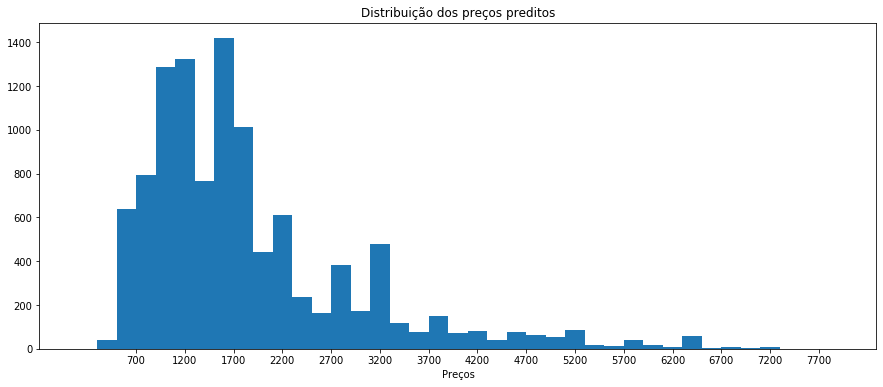

In [45]:
plt.figure(figsize=(15, 6))
plt.hist(df_final_media['preco_predito'].tolist(), bins=range(100, 8000,200))
plt.title('Distribuição dos preços preditos')
plt.xticks(range(700, 8000,500))
plt.xlabel('Preços')
# plt.ylabel('Alunos')
# plt.savefig('imagens/peso-histograma.png')
# plt.close()

In [130]:
predict_teste = data
# [(data.marca_renomeado_upper == 'IPHONE 7') & (data.condition == 'used')]
predict_teste

,memoria_interna,memoria_ram,quantidade_sims,ano_lancamento,marca_renomeado_upper,condition,Linha,Marca,price
5,64,4.0,2.0,2019.0,REDMI NOTE 8,new,Redmi,Xiaomi,1170.5
6,64,4.0,2.0,2019.0,REDMI NOTE 8,new,Redmi,Xiaomi,1278.0
7,64,4.0,2.0,2019.0,REDMI NOTE 8,new,Redmi,Xiaomi,1266.0
8,64,4.0,2.0,2019.0,REDMI NOTE 8,new,Redmi,Xiaomi,1248.0
9,64,4.0,2.0,2019.0,REDMI NOTE 8,new,Redmi,Xiaomi,1310.0
...,...,...,...,...,...,...,...,...,...
24216,64,64.0,1.0,2018.0,IPHONE XR,used,iPhone,Apple,2959.9
24217,64,4.0,2.0,2019.0,REDMI NOTE 8,used,Redmi,Xiaomi,1350.0
24219,64,3.0,1.0,2016.0,IPHONE 8 PLUS,used,iPhone,Apple,2300.0
24220,256,8.0,1.0,2021.0,POCO X3 PRO,new,Redmi,Xiaomi,2239.0


In [53]:
import pickle

filename = 'precificacao_xboostFinal.pk1'
pickle.dump(best_model, open(filename, 'wb'))

In [190]:
# import joblib
# model = joblib.load("precificacao_xboost.pk1")
# model.get_booster().feature_names = ["your", "feature", "name", "list"]
# xgboost.plot_importance(model.get_booster())

In [192]:
# model.n_features_in_

35